# N-BEATS: Neural basis expansion analysis for interpretable time series forecasting
Project by: Hamdi BEL HADJ HASSINE & Sami AMRANI (group 55)

In [ ]:
%cd N-BEATS

In [4]:
import os
os.environ["STORAGE"] = ""
import logging
from typing import Dict
from typing import Iterator
import shutil
import gin
gin.enter_interactive_mode()
import numpy as np
import pandas as pd
import torch as t
import joblib
from glob import glob
import itertools
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from tqdm import tqdm
import scipy
import re

from common.experiment import Experiment
from common.sampler import TimeseriesSampler
from common.torch.ops import to_tensor
from common.torch.snapshots import SnapshotManager
from common.torch.losses import smape_2_loss, mape_loss, mase_loss
from datasets.m3 import M3Dataset, M3Meta
from experiments.trainer_original import trainer
from experiments.model import generic, interpretable
from summary.utils import group_values
from time import time

## Training the models with the original implementation code
The code in the next 3 cells is taken from the official implementation of N-BEATS: https://github.com/ElementAI/N-BEATS

The rest of the notebook is >90% ours (but the code in the .py files is from the official implementation (except a few modifications); only this notebook is ours).

In [ ]:
class M3Experiment(Experiment):
    @gin.configurable()
    def instance(self,
                 repeat: int,
                 lookback: int,
                 loss: str,
                 history_size: Dict[str, int],
                 iterations: Dict[str, int],
                 model_type: str):
        dataset = M3Dataset.load(training=True)

        forecasts = []
        for seasonal_pattern in M3Meta.seasonal_patterns:
            sp_history_size = history_size[seasonal_pattern]
            horizon = M3Meta.horizons_map[seasonal_pattern]
            input_size = lookback * horizon

            # Training Set
            training_values = group_values(dataset.values, dataset.groups, seasonal_pattern)

            training_set = TimeseriesSampler(timeseries=training_values,
                                             insample_size=input_size,
                                             outsample_size=horizon,
                                             window_sampling_limit=int(sp_history_size * horizon))
            if model_type == 'interpretable':
                model = interpretable(input_size=input_size, output_size=horizon)
            elif model_type == 'generic':
                model = generic(input_size=input_size, output_size=horizon)
            else:
                raise Exception(f'Unknown model type {model_type}')

            # Train model
            snapshot_manager = SnapshotManager(snapshot_dir=os.path.join(self.root, 'snapshots', seasonal_pattern),
                                               total_iterations=iterations[seasonal_pattern])
            model = trainer(snapshot_manager=snapshot_manager,
                            model=model,
                            training_set=iter(training_set),
                            timeseries_frequency=M3Meta.frequency_map[seasonal_pattern],
                            loss_name=loss,
                            iterations=iterations[seasonal_pattern])

            # Build forecasts
            x, x_mask = map(to_tensor, training_set.last_insample_window())
            model.eval()
            with t.no_grad():
                forecasts.extend(model(x, x_mask).cpu().detach().numpy())

        forecasts_df = pd.DataFrame(forecasts, columns=[f'V{i + 1}' for i in range(np.max(M3Meta.horizons))])
        forecasts_df.index = dataset.ids
        forecasts_df.index.name = 'id'
        forecasts_df.to_csv(os.path.join(self.root, 'forecast.csv'))

In [ ]:
xp = M3Experiment("experiments/m3/interpretable.gin")

In [ ]:
# Train the 180 models and save their forecasts
# takes more than 24 hours to run
lookbacks = [2, 3, 4, 5, 6, 7]
losses = ['MASE', 'MAPE', 'SMAPE']
repeats = list(range(10))
for repeat in repeats:
    for lookback in lookbacks:
        for loss in losses:
            xp.instance(lookback=lookback, loss=loss, repeat=repeat)
            os.makedirs(f"experiments/m3_interpretable/{lookback}{loss}{repeat}/", exist_ok=True)
            shutil.move("experiments/m3/forecast.csv",
                        f"experiments/m3_interpretable/{lookback}{loss}{repeat}/forecast.csv")
            shutil.rmtree("experiments/m3/snapshots")

/content/drive/MyDrive/Projects/MLTS/N-BEATS/summary/utils.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([v[~np.isnan(v)] for v in values[groups == group_name]])


## Impact of the number of repeats on the model's performance

In [40]:
# load the test set
from datasets.m3 import M3Dataset
test_set = M3Dataset.load(training=False)

In [1768]:
# get the forecasts from the files
def get_forecasts(path):
    df = []
    for file in glob(path):
        df.append(pd.read_csv(file))
        save_name = re.findall(r".+/.+/(\d+)([a-zA-Z]+)(\d+)/", file)[0]
        df[-1]["lookback"] = int(save_name[0])
        df[-1]["loss"] = save_name[1]
        df[-1]["repeat"] = int(save_name[2])
    df = pd.concat(df, axis=0)
    return(df)
df = get_forecasts("experiments/m3_interpretable/**/forecast.csv")

In [1769]:
df

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V12,V13,V14,V15,V16,V17,V18,lookback,loss,repeat
0,N 1,5335.4746,5546.0490,5873.3910,6018.0370,6287.4710,6283.6930,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,MAPE,5
1,N 2,4161.6523,4090.9460,3971.2660,4075.4473,3918.7769,3974.7220,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,MAPE,5
2,N 3,3418.3580,3333.4714,3207.8657,3307.9600,3136.2050,3163.9934,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,MAPE,5
3,N 4,4657.9873,4668.0654,4660.6445,4773.9795,4751.6920,4826.7710,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,MAPE,5
4,N 5,5423.3496,5365.1930,5212.8910,5293.3506,5135.1370,5207.5073,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,MAPE,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998,N2999,1550.6357,1531.1792,1518.4886,1501.8447,1486.7896,1476.2451,1460.138550,1448.633789,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,MAPE,8
2999,N3000,1606.3242,1578.3130,1539.6438,1512.3495,1470.8779,1442.5327,1409.660400,1397.791138,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,MAPE,8
3000,N3001,7666.5625,7341.6590,6903.3810,6581.9660,6108.3125,5848.0750,5298.931641,5362.956055,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,MAPE,8
3001,N3002,11023.8200,10909.7610,10829.1610,10736.1390,10629.3670,10526.7670,10461.510742,10329.201172,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,MAPE,8


In [110]:
def ensemble_forecasts(df, lookback="all", loss="all", repeat="all"):
    # replace "all" by all possible values, for each of lookback, loss, repeat
    # and put them in lists
    if lookback=="all":
        lookback = list(df["lookback"].unique())
    elif not(isinstance(lookback, list)):
        lookback = [lookback]
    if loss=="all":
        loss = list(df["loss"].unique())
    elif not(isinstance(loss, list)):
        loss = [loss]
    if repeat=="all":
        repeat = list(df["repeat"].unique())
    elif not(isinstance(repeat, list)):
        repeat = [repeat]
    # filter
    df = df[(df["lookback"].isin(lookback)) & (df["loss"].isin(loss)) & (df["repeat"].isin(repeat))]
    # take the median value for each series
    value_cols = [x for x in df.columns if x[0]=='V']
    df = df[['id']+value_cols].groupby('id', sort=False).median()
    return(df)

In [113]:
ens = ensemble_forecasts(df)

In [1610]:
def smape(forecast, target):
    return np.mean(200 * np.abs((forecast - target) / (target + forecast)))

def mape(forecast, target):
    return np.mean(100 * np.abs((forecast - target) / target))

def mdape(forecast, target):
    return np.median(100 * np.abs((forecast - target) / target))

def calc_error(test_set, ens, error="smape", indices=None, horizons=None):
    """Calculate the error metrics given the forecasts (ens) and target dataset (test_set)"""
    # initialization
    if indices is None:  # indices: series indices to be considered, the others are ignored
        indices = list(range(len(ens)))
    indices = [x in indices for x in range(len(ens))] # convert to list of bools
    l_error = []
    error_sum, n_forecasts = 0, 0
    for seasonal_pattern in ['M3Year', 'M3Quart', 'M3Month', 'M3Other']:
        # target values (ground truth) for this seasonal pattern
        target_values = test_set.values[(test_set.groups == seasonal_pattern) & indices]
        target_values = np.array([target_values[i] for i in range(len(target_values))])
        if not(horizons is None): target_values = target_values[:,horizons]
        # forecast values (as ndarray)
        forecast_values = ens.iloc[(test_set.groups == seasonal_pattern) & indices].dropna(axis=1).to_numpy()
        if not(horizons is None): forecast_values = forecast_values[:,horizons]
        # seasonal pattern error
        error = error.lower()
        sp_error = eval(f"{error}(forecast_values, target_values)")
        l_error.append(sp_error)
        error_sum += sp_error*forecast_values.shape[0]*forecast_values.shape[1]
        n_forecasts += forecast_values.shape[0]*forecast_values.shape[1]
    l_error.append(error_sum/n_forecasts)
    return(l_error)

In [942]:
l_nb_repeats = list(range(1,11)) # nb of repeats
l_repeats = list(range(10)) # repeat ids
df_res = pd.DataFrame(columns=['Year','Quart','Month','Other','Average'], index=l_nb_repeats)
df_std = pd.DataFrame(columns=['Year','Quart','Month','Other','Average'], index=l_nb_repeats)
for ensemble_size in l_nb_repeats: # number of repeats in the ensemble
    l_err = []
    for repeat in itertools.combinations(l_repeats, ensemble_size): # all ensemble_size-combinations of repeats
        ens = ensemble_forecasts(df, repeat=list(repeat))
        l_err.append(calc_error(test_set, ens))
    df_res.loc[ensemble_size] = np.mean(l_err, axis=0)
    if ensemble_size<10: # can't calculate std from one sample
        df_std.loc[ensemble_size] = np.std(l_err, axis=0, ddof=1)
df_res # Obtained sMAPE per number of repeats used. 10 repeats = all the 180 models

,Year,Quart,Month,Other,Average
1,15.831604,9.062039,13.414405,4.251458,12.611375
2,15.814352,9.021735,13.349465,4.249382,12.55781
3,15.808524,9.007037,13.327489,4.247573,12.53947
4,15.805079,8.998785,13.316374,4.246808,12.530014
5,15.802654,8.993762,13.309706,4.246406,12.524294
6,15.800654,8.990231,13.305476,4.246051,12.520557
7,15.799091,8.987585,13.302553,4.245724,12.51792
8,15.79782,8.985751,13.300174,4.245333,12.51582
9,15.797395,8.983769,13.298514,4.244793,12.514279
10,15.796326,8.98326,13.296547,4.244021,12.512689


In [943]:
df_std # standard deviation of the error per number of repeats

,Year,Quart,Month,Other,Average
1,0.033647,0.053161,0.029664,0.04599,0.021375
2,0.02344,0.035127,0.021212,0.03118,0.015307
3,0.018684,0.026139,0.016922,0.024317,0.012065
4,0.015197,0.020894,0.013216,0.019699,0.009361
5,0.012467,0.016779,0.010872,0.016277,0.007683
6,0.010095,0.013679,0.008915,0.01345,0.006203
7,0.008057,0.010737,0.007247,0.011105,0.005043
8,0.006052,0.008021,0.005808,0.008768,0.004008
9,0.003832,0.00532,0.004243,0.0063,0.002889
10,NaN,NaN,NaN,NaN,NaN


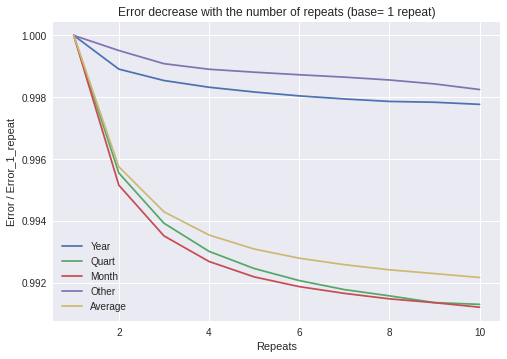

In [964]:
# Scale and plot
df_res_ = df_res.copy()
for j in range(len(df_res_.columns)):
    df_res_.iloc[:,j] = df_res_.iloc[:,j] / df_res_.iloc[0,j]
df_res_.plot(title = "SMAPE Error decrease with the number of repeats (base= 1 repeat)", xlabel="Repeats", ylabel = "Error / Error_1_repeat");

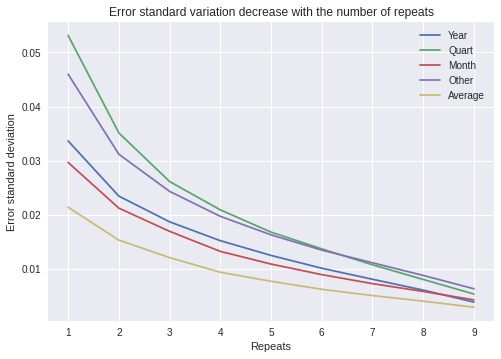

In [965]:
df_std.plot(title = "SMAPE Error standard variation decrease with the number of repeats", xlabel="Repeats", ylabel = "Error standard deviation");

Using bigger ensembles improves the forecasting performance and makes the model's performance more consistent, but the difference in performance is small: Using an ensemble of 180 models (10 repeats) decreseas the error rate by less than 1% compared to an ensemble of 18 models (1 repeat). We also note that the performance gain depends on the model's and the series' parameters; in particular models which were trained on longer series (Yearly and Other) profited less from increasing the ensemble size.

## Impact of the lookback
### Over ensembles of 30 models (using all repeats):
Lookback = 2 yields the best performance:

In [985]:
l_lookbacks = list(range(2,8)) # lookback ids
df_res = pd.DataFrame(columns=['Year','Quart','Month','Other','Average'], index=l_lookbacks)
for lookback in l_lookbacks:
    ens = ensemble_forecasts(df, lookback=lookback)
    df_res.loc[lookback] = calc_error(test_set, ens)
df_res.style.highlight_min()

,Year,Quart,Month,Other,Average
2,15.803482,9.100530,13.491941,4.116667,12.663498
3,15.834913,9.129088,13.556119,4.224813,12.720086
4,15.876616,9.462552,13.597063,4.281717,12.809506
5,15.933759,9.601037,13.619582,4.304928,12.854621
6,15.940410,9.595369,13.895220,4.299146,13.045586
7,15.942769,9.816199,14.102468,4.378003,13.228803


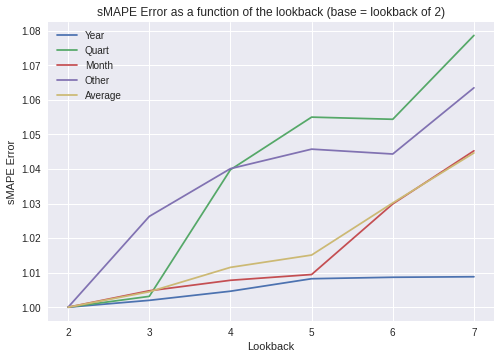

In [986]:
# Scale and plot
df_res_ = df_res.copy()
for j in range(len(df_res_.columns)):
    df_res_.iloc[:,j] = df_res_.iloc[:,j] / df_res_.iloc[0,j]
df_res_.plot(title = "sMAPE Error as a function of the lookback (base = lookback of 2)", xticks=l_lookbacks,
            xlabel="Lookback", ylabel = "sMAPE Error");

### Over ensembles of 3 models (using 1 repeat):
The results are very similar except that errors are higher because we use smaller ensembles.

Now we can compute standard errors: They don't seem to have a clear correlation with the lookbacks, i.e. there is no lookback that makes the model's performance more consistent.

In [987]:
l_lookbacks = list(range(2,8)) # lookback ids
df_res = pd.DataFrame(columns=['Year','Quart','Month','Other','Average'], index=l_lookbacks)
df_std = pd.DataFrame(columns=['Year','Quart','Month','Other','Average'], index=l_lookbacks)
for lookback in l_lookbacks:
    l_err = []
    for repeat in l_repeats:
        ens = ensemble_forecasts(df, lookback=lookback, repeat=repeat)
        l_err.append(calc_error(test_set, ens))
    df_res.loc[lookback] = np.mean(l_err, axis=0)
    df_std.loc[lookback] = np.std(l_err, axis=0, ddof=1)
df_res.style.highlight_min()

,Year,Quart,Month,Other,Average
2,15.935483,9.496459,14.266448,4.141260,13.280767
3,15.967767,9.518991,14.301300,4.251303,13.316165
4,15.950962,10.029729,14.252464,4.327564,13.366816
5,16.032619,9.967464,14.270073,4.340531,13.377895
6,16.108067,10.012782,14.652842,4.353577,13.659490
7,16.119874,10.213373,16.145446,4.417861,14.732442


In [989]:
df_std.style.highlight_min()

,Year,Quart,Month,Other,Average
2,0.140103,0.118517,0.139605,0.043004,0.109697
3,0.187625,0.080372,0.301949,0.094624,0.215421
4,0.084637,0.631581,0.089070,0.087798,0.136185
5,0.090323,0.096079,0.124844,0.128970,0.089220
6,0.205568,0.121871,0.209626,0.074569,0.151368
7,0.101053,0.113255,1.810204,0.083235,1.251132


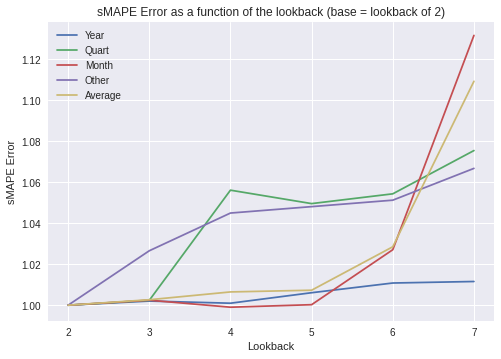

In [978]:
# Scale and plot
df_res_ = df_res.copy()
for j in range(len(df_res_.columns)):
    df_res_.iloc[:,j] = df_res_.iloc[:,j] / df_res_.iloc[0,j]
df_res_.plot(title = "sMAPE Error as a function of the lookback (base = lookback of 2)", xticks=l_lookbacks,
            xlabel="Lookback", ylabel = "sMAPE Error");

### Over ensembles including repeats 2 to k, k in \{2,.., 7\}
Lower lookbacks seem to work better, so we examine which combination of lookbacks (2 to k) is the best → Lookback combination (2 to 5)

In [ ]:
def highlight_max(s):
    if s.dtype == np.object:
        is_max = [False for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
    return ['background: lightgreen' if cell else '' for cell in is_max]

In [983]:
l_lookbacks = list(range(2,8)) # lookback ids
df_res = pd.DataFrame(columns=['Year','Quart','Month','Other','Average'], index=l_lookbacks)
for lookback in l_lookbacks:
    ens = ensemble_forecasts(df, lookback=list(range(2,lookback+1)))
    df_res.loc[lookback] = calc_error(test_set, ens)
df_res.style.highlight_min()

,Year,Quart,Month,Other,Average
2,15.803482,9.100530,13.491941,4.116667,12.663498
3,15.800054,8.848175,13.298329,4.160937,12.489119
4,15.780877,8.824864,13.305595,4.188005,12.489369
5,15.792372,8.817637,13.264860,4.226835,12.462562
6,15.787509,8.882330,13.290231,4.253033,12.491228
7,15.796326,8.983260,13.296547,4.244021,12.512689


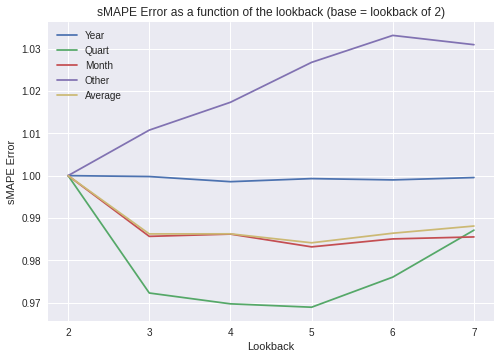

In [982]:
# Scale and plot
df_res_ = df_res.copy()
for j in range(len(df_res_.columns)):
    df_res_.iloc[:,j] = df_res_.iloc[:,j] / df_res_.iloc[0,j]
df_res_.plot(title = "sMAPE Error as a function of the lookback (base = lookback of 2)", xticks=l_lookbacks,
            xlabel="Lookback", ylabel = "sMAPE Error");

# Impact of the loss function


In [1208]:
# Calculate sMAPE for each loss function's trained models
l_losses = ['MAPE', 'SMAPE', 'MASE']
df_res = pd.DataFrame(columns=['Year','Quart','Month','Other','Average'], index=l_losses)
df_std = pd.DataFrame(columns=['Year','Quart','Month','Other','Average'], index=l_losses)
for loss in l_losses:
    l_err = []
    for repeat in l_repeats:
        ens = ensemble_forecasts(df, loss=loss, repeat=repeat)
        l_err.append(calc_error(test_set, ens))
    df_res.loc[loss] = np.mean(l_err, axis=0)
    df_std.loc[loss] = np.std(l_err, axis=0, ddof=1)
df_res.style.highlight_min()

,Year,Quart,Month,Other,Average
MAPE,16.302894,9.383536,13.721224,4.205111,12.924506
SMAPE,15.838735,9.252607,13.635591,4.294521,12.798478
MASE,16.217017,9.168760,14.195613,4.280004,13.212685


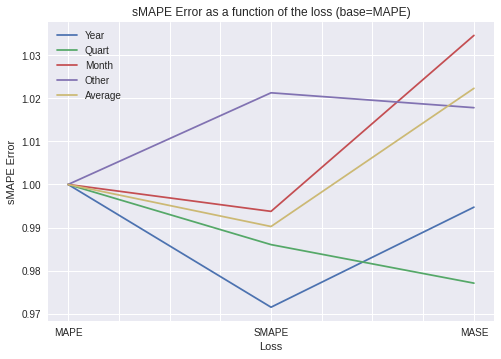

In [1210]:
# Scale and plot
df_res_ = df_res.copy()
for j in range(len(df_res_.columns)):
    df_res_.iloc[:,j] = df_res_.iloc[:,j] / df_res_.iloc[0,j]
df_res_.plot(title = "sMAPE Error as a function of the loss (base=MAPE)",
            xlabel="Loss", ylabel = "sMAPE Error");

Now we plot MAPE errors:

In [1215]:
l_losses = ['MAPE', 'SMAPE', 'MASE']
df_res = pd.DataFrame(columns=['Year','Quart','Month','Other','Average'], index=l_losses)
df_std = pd.DataFrame(columns=['Year','Quart','Month','Other','Average'], index=l_losses)
for loss in l_losses:
    l_err = []
    for repeat in l_repeats:
        ens = ensemble_forecasts(df, loss=loss, repeat=repeat)
        l_err.append(calc_error(test_set, ens, error="MAPE"))
    df_res.loc[loss] = np.mean(l_err, axis=0)
    df_std.loc[loss] = np.std(l_err, axis=0, ddof=1)
df_res.style.highlight_min()

,Year,Quart,Month,Other,Average
MAPE,20.086155,11.969417,17.760905,4.479913,16.558243
SMAPE,21.144611,12.014201,18.677409,4.683529,17.320341
MASE,22.694895,12.141287,20.613216,4.746384,18.849862


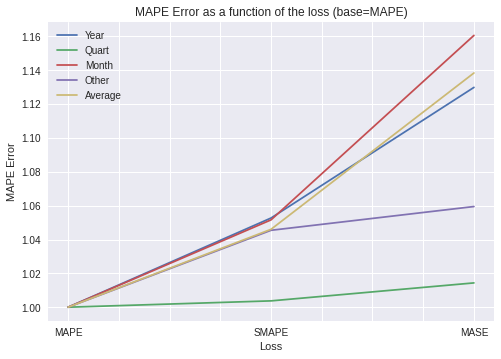

In [1217]:
# Scale and plot
df_res_ = df_res.copy()
for j in range(len(df_res_.columns)):
    df_res_.iloc[:,j] = df_res_.iloc[:,j] / df_res_.iloc[0,j]
df_res_.plot(title = "MAPE Error as a function of the loss (base=MAPE)",
            xlabel="Loss", ylabel = "MAPE Error");

Now we plot MdAPE errors:

In [1218]:
l_losses = ['MAPE', 'SMAPE', 'MASE']
df_res = pd.DataFrame(columns=['Year','Quart','Month','Other','Average'], index=l_losses)
df_std = pd.DataFrame(columns=['Year','Quart','Month','Other','Average'], index=l_losses)
for loss in l_losses:
    l_err = []
    for repeat in l_repeats:
        ens = ensemble_forecasts(df, loss=loss, repeat=repeat)
        l_err.append(calc_error(test_set, ens, error="MdAPE"))
    df_res.loc[loss] = np.mean(l_err, axis=0)
    df_std.loc[loss] = np.std(l_err, axis=0, ddof=1)
df_res.style.highlight_min()

,Year,Quart,Month,Other,Average
MAPE,8.796179,4.308596,6.562498,2.035560,6.257512
SMAPE,8.516658,4.291427,6.499343,2.053317,6.182292
MASE,8.783801,4.236970,6.443752,2.076888,6.163607


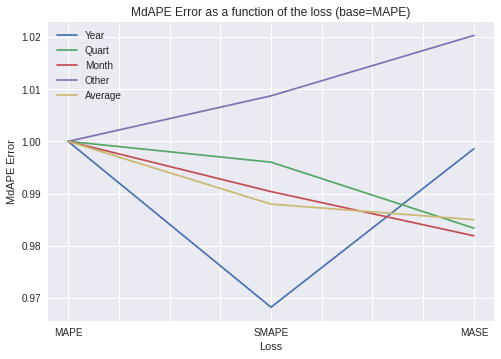

In [1219]:
# Scale and plot
df_res_ = df_res.copy()
for j in range(len(df_res_.columns)):
    df_res_.iloc[:,j] = df_res_.iloc[:,j] / df_res_.iloc[0,j]
df_res_.plot(title = "MdAPE Error as a function of the loss (base=MAPE)",
            xlabel="Loss", ylabel = "MdAPE Error");

We observe that:

1. As expected, optimizing over a loss yields a model that tends to achieve lower errors with respect to the given loss.

2. Median percentage errors (MdAPE) are much lower than mean percentage errors (MAPE), meaning that errors' distribution has a thick tail and a minority of hard-to-forecast target values account for most of the MAPE error.

Now we assume that we want to minimize the sMAPE loss, we compare models using the sMAPE loss along with different combinations of the other losses. For a fairer comparison we adjust the number of repeats so we always use ensembles of 60 models. Here we denote MAPE as P, SMAPE as SP and MASE as S.

In [1251]:
l_losses = ['SP', 'SP,P', 'SP,S', 'SP,P,S']
df_res = pd.DataFrame(columns=['Year','Quart','Month','Other','Average'], index=l_losses)
for losses in l_losses:
    loss = list(map({'SP':'SMAPE','S':'MASE','P':'MAPE'}.get, losses.split(',')))
    if len(loss)==1:
        repeat = "all"
        ens = ensemble_forecasts(df, loss=loss, repeat=repeat)
    elif len(loss)==2:
        repeat = list(range(5))
        ens = ensemble_forecasts(df, loss=loss, repeat=repeat)
    elif len(loss)==3:
        # We adjust the repeats in the ensemble to get 60 models
        lookback = list(df["lookback"].unique())
        loss = list(df["loss"].unique())
        # get forecasts of sMAPE with 4 repeats
        repeat = list(range(4))
        df1 = df[(df["lookback"].isin(lookback)) & (df["loss"]=="SMAPE") & (df["repeat"].isin(repeat))]
        # get forecasts of MAPE with 3 repeats
        repeat = list(range(3))
        df2 = df[(df["lookback"].isin(lookback)) & (df["loss"]=="MAPE") & (df["repeat"].isin(repeat))]
        # get forecasts of MASE with 3 repeats
        repeat = list(range(3))
        df3 = df[(df["lookback"].isin(lookback)) & (df["loss"]=="MASE") & (df["repeat"].isin(repeat))]
        # concatenate them
        df4 = pd.concat([df1,df2,df3], axis=0)
        # get ensemble
        value_cols = [x for x in df.columns if x[0]=='V']
        ens = df1[['id']+value_cols].groupby('id').median()
    df_res.loc[losses] = calc_error(test_set, ens)
df_res.style.highlight_min()

,Year,Quart,Month,Other,Average
SP,15.790113,9.053549,13.336965,4.279160,12.552914
"SP,P",15.911693,9.046219,13.321855,4.217997,12.551634
"SP,S",15.912629,8.966877,13.388968,4.304479,12.588626
"SP,P,S",15.813857,9.101602,13.375382,4.284826,12.590139


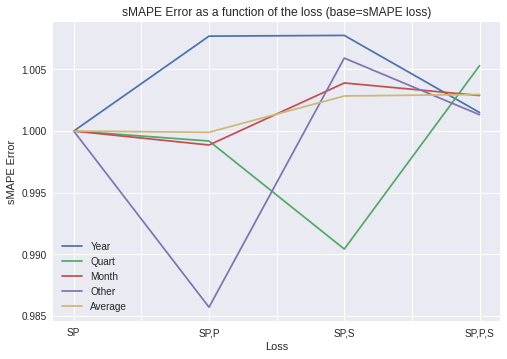

In [1254]:
# Scale and plot
df_res_ = df_res.copy()
for j in range(len(df_res_.columns)):
    df_res_.iloc[:,j] = df_res_.iloc[:,j] / df_res_.iloc[0,j]
df_res_.plot(title = "sMAPE Error as a function of the loss (base=sMAPE loss)",
            xlabel="Loss", ylabel = "sMAPE Error");

We can conclude that for fixed ensemble size, the best results are obtained when using either only the sMAPE loss (SP on the plot) or mixing models with sMAPE and MAPE losses (SP,P). However, the difference between them is very small, and using all losses would also improve the model's performance when evaluated with other losses, so there is no clear winner here.

# Comparison with other forecasting models
We use the Darts package which includes implementations of the most popular forecasting models (note: Darts also includes an implementation of N-BEATS, but its performance is largely below that of the official implementation; we spent a lot of time trying to debug it but we ended up switching to the official implementation, which works better but doesn't offer an intuitive API like Darts).

We make forecasts for the M3 dataset using exponential smoothing:

In [1255]:
#!pip install darts
from darts import TimeSeries
from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing
from darts.models.forecasting.auto_arima import AutoARIMA

In [1256]:
dataset = M3Dataset.load(training=True)

In [1269]:
horizons_map = {'M3Year': 6, 'M3Quart': 8, 'M3Month': 18, 'M3Other': 8}
frequency_map = {'M3Year': 1,'M3Quart': 4,'M3Month': 12,'M3Other': 1}

In [1382]:
%%capture
# Initialization
forecasts = np.zeros((len(dataset.values),18))
forecasts[:] = np.nan
for i in range(len(dataset.values)):
    # Convert to timeSeries, create model, fit, predict, save forecasts
    series = dataset.values[i]
    series = TimeSeries.from_values(series)
    seasonality = frequency_map[dataset.groups[i]]
    if seasonality==1:
        model = ExponentialSmoothing(seasonal=None, damped=True)
    else:
        model = ExponentialSmoothing(seasonal_periods=seasonality, damped=True)
    model.fit(series)
    prediction = model.predict(horizons_map[dataset.groups[i]])
    forecasts[i,:len(prediction)] = prediction.values().flatten()

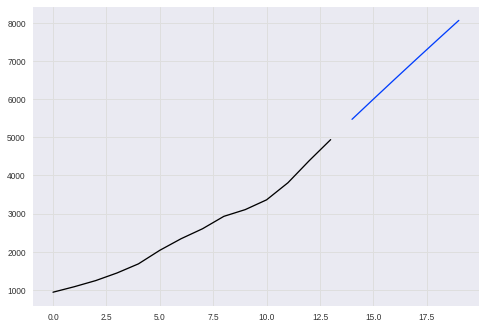

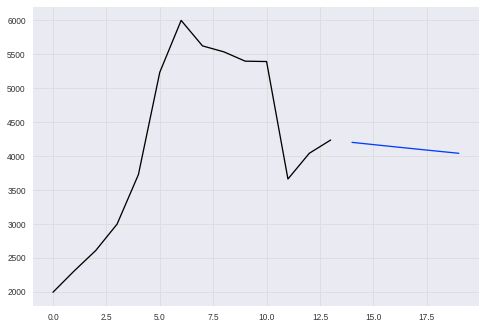

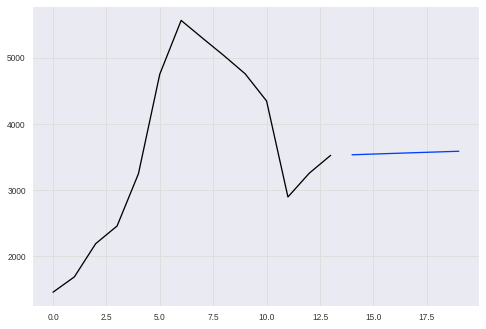

In [1395]:
# Sanity check: plot first 3 forecasts
for i in range(3):
    len_train = len(dataset.values[i])
    plt.plot(range(len_train), list(dataset.values[i]))
    plt.plot(range(len_train, len_train+len(forecasts[i])), list(forecasts[i]))
    plt.show()
# forecasts are quasilinear but this is an expected characteristic for non-seasonal series
# https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html

In [1383]:
forecasts_df_es = pd.DataFrame(forecasts, columns=[f'V{i + 1}' for i in range(18)])
forecasts_df_es.index = dataset.ids
forecasts_df_es.index.name = 'id'
forecasts_df_es.to_csv('es_forecast.csv')

In [1398]:
forecasts_df_es

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18
id,,,,,,,,,,,,,,,,,,
N 1,5469.332488,5996.987352,6519.838603,7037.929970,7551.304787,8060.005991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N 2,4195.395301,4162.591933,4130.116599,4097.966018,4066.136943,4034.626159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N 3,3533.547668,3544.396715,3555.137272,3565.770424,3576.297243,3586.718795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N 4,4786.848551,4932.166980,5066.895921,5191.807039,5307.615769,5414.985409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N 5,5291.226940,5236.538042,5183.435123,5131.872188,5081.804578,5033.188928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N2999,1544.995755,1525.097063,1505.303435,1485.614318,1466.029159,1446.547410,1427.168524,1407.891959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N3000,1603.966011,1574.241828,1544.814886,1515.682214,1486.840869,1458.287937,1430.020535,1402.035806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N3001,7718.713165,7389.647603,7064.108713,6742.058699,6423.460170,6108.276135,5796.470000,5488.005564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we forecast using Auto-ARIMA (since we can't manually select the ARIMA parameters for each of the 3003 series)

In [1340]:
%%capture
forecasts = np.zeros((len(dataset.values),18))
forecasts[:] = np.nan
indices = [] # indices of forecasted series
for i in range(len(dataset.values)):
    series = dataset.values[i]
    if len(series)>=30: # Darts' Auto-ARIMA only works for series with >= 30 obs.
        try: # Rarely, the model fit fails and returns an error
            series = TimeSeries.from_values(series)
            model = AutoARIMA()
            model.fit(series)
            prediction = model.predict(horizons_map[dataset.groups[i]])
            forecasts[i,:len(prediction)] = prediction.values().flatten()
            indices.append(i)
        except:
            pass

In [1345]:
len(indices), len(dataset.values) # we have forecasts for >80% of the series

(2444, 3003)

In [1341]:
forecasts_df_arima = pd.DataFrame(forecasts, columns=[f'V{i + 1}' for i in range(18)])
forecasts_df_arima.index = dataset.ids
forecasts_df_arima.index.name = 'id'
forecasts_df_arima.to_csv('arima_forecast.csv')

Naive forecasts (repeat the last observation):

In [1399]:
forecasts_df_naive = forecasts_df.copy()
for i in range(len(forecasts_df)):
    forecasts_df_naive.iloc[i,:horizons_map[dataset.groups[i]]] = dataset.values[i][-1]

Plot the forecast errors:

In [1424]:
ens = ensemble_forecasts(df) # 180-model N-BEATS ensemble
plot_df = pd.DataFrame([calc_error(test_set, ens, indices=indices),
                      calc_error(test_set, forecasts_df_arima, indices=indices),
                      calc_error(test_set, forecasts_df_es, indices=indices),
                      calc_error(test_set, forecasts_df_naive, indices=indices)],
                      columns=['Year', 'Quart', 'Month', 'Other','Average'],
                      index=['N-BEATS','ARIMA','ES','Naive'])

In [1425]:
plot_df.style.highlight_min()

,Year,Quart,Month,Other,Average
N-BEATS,16.017492,9.401282,13.296547,4.244021,12.367020
ARIMA,19.362063,10.847078,16.433849,4.307990,15.108046
ES,20.237714,16.388067,18.392667,4.427583,17.540601
Naive,16.361535,11.831233,18.185436,6.301606,16.607246


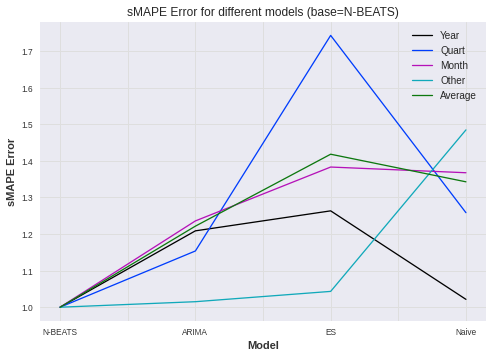

In [1426]:
# Scale and plot
for j in range(len(df_res_.columns)):
    plot_df.iloc[:,j] = plot_df.iloc[:,j] / plot_df.iloc[0,j]
plot_df.plot(title = "sMAPE Error for different models (base=N-BEATS)",
            xlabel="Model", ylabel = "sMAPE Error");

We see that N-BEATS beats the three other methods at all four seasonality patterns, confirming the results published in the paper. However, the paper didn't include other error metrics for the M3 dataset (which is understandable because sMAPE was used as the M3 competition metric). We recompute the results for MAPE and MdAPE:

In [1435]:
ens = ensemble_forecasts(df) # 180-model N-BEATS ensemble
plot_df = pd.DataFrame([calc_error(test_set, ens, error="MAPE", indices=indices),
                      calc_error(test_set, forecasts_df_arima, error="MAPE", indices=indices),
                      calc_error(test_set, forecasts_df_es, error="MAPE", indices=indices),
                      calc_error(test_set, forecasts_df_naive, error="MAPE", indices=indices)],
                      columns=['Year', 'Quart', 'Month', 'Other','Average'],
                      index=['N-BEATS','ARIMA','ES','Naive'])
plot_df.style.highlight_min()

,Year,Quart,Month,Other,Average
N-BEATS,19.522768,12.447407,18.277639,4.611466,16.799499
ARIMA,23.026301,14.484686,23.205153,4.664443,21.013979
ES,25.368963,13.583208,21.931865,4.901367,19.968683
Naive,18.165753,15.002250,28.104652,7.025130,24.813486


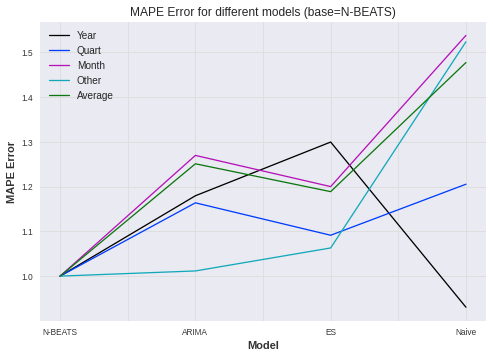

In [1436]:
# Scale and plot
for j in range(len(df_res_.columns)):
    plot_df.iloc[:,j] = plot_df.iloc[:,j] / plot_df.iloc[0,j]
plot_df.plot(title = "MAPE Error for different models (base=N-BEATS)",
            xlabel="Model", ylabel = "MAPE Error");

In [1437]:
ens = ensemble_forecasts(df) # 180-model N-BEATS ensemble
plot_df = pd.DataFrame([calc_error(test_set, ens, error="MdAPE", indices=indices),
                      calc_error(test_set, forecasts_df_arima, error="MdAPE", indices=indices),
                      calc_error(test_set, forecasts_df_es, error="MdAPE", indices=indices),
                      calc_error(test_set, forecasts_df_naive, error="MdAPE", indices=indices)],
                      columns=['Year', 'Quart', 'Month', 'Other','Average'],
                      index=['N-BEATS','ARIMA','ES','Naive'])
plot_df.style.highlight_min()

,Year,Quart,Month,Other,Average
N-BEATS,8.795395,4.473482,6.221797,2.047196,5.839192
ARIMA,10.408999,5.237488,7.583807,1.888324,7.048233
ES,11.225762,4.911223,7.007977,1.938203,6.579309
Naive,9.205530,5.780015,8.780310,4.106291,8.111379


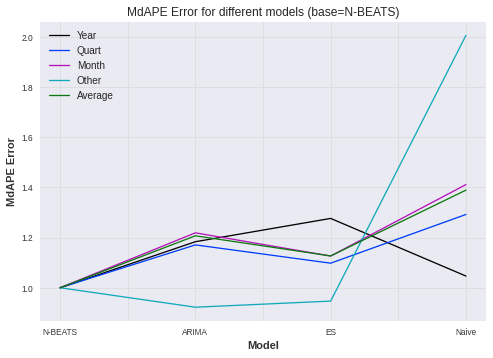

In [1438]:
# Scale and plot
for j in range(len(df_res_.columns)):
    plot_df.iloc[:,j] = plot_df.iloc[:,j] / plot_df.iloc[0,j]
plot_df.plot(title = "MdAPE Error for different models (base=N-BEATS)",
            xlabel="Model", ylabel = "MdAPE Error");

We see that on average N-BEATS still outperforms the other methods, but it is sometimes beaten for a few subsets of the series. We note however that although all of the 3 other methods managed to outperform N-BEATS for one of the seasonal patterns and one of the error metrics, they all also have errors 25% to 100% higher than N-BEATS, while N-BEATS manages to achieve consistent performance and is only slightly and rarely outperformed.

Overall, we can conclude that N-BEATS displays outstanding forecasting performance and manages to outperform popular models like ARIMA and Exponential Smoothing, although it is less interpretable.

# Impact of the forecast horizon
Here we use predictions from the 180-model ensemble (for more significant results) and evaluate its performance for single-point forecasts of different horizons.

In [1616]:
ens = ensemble_forecasts(df)
l_horizons = list(range(6))
df_res = pd.DataFrame(columns=['Year','Quart','Month','Other','Average'], index=np.array(l_horizons)+1)
for horizon in l_horizons:
    df_res.loc[horizon+1] = calc_error(test_set, ens, horizons=[horizon])
df_res.style.highlight_min()

,Year,Quart,Month,Other,Average
1,7.551132,4.516990,11.135205,1.739034,8.154842
2,11.529163,6.404731,10.244329,2.711683,9.117223
3,15.731612,7.255255,11.761530,3.745216,11.015316
4,17.727403,8.462270,12.026222,4.182485,11.899050
5,20.559551,9.436951,10.900169,5.223807,12.277598
6,21.679098,11.244722,12.107139,4.930440,13.530109


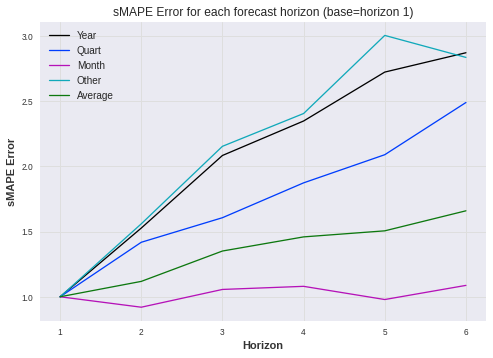

In [1617]:
# Scale and plot
for j in range(len(df_res.columns)):
    df_res.iloc[:,j] = df_res.iloc[:,j] / df_res.iloc[0,j]
df_res.plot(title = "sMAPE Error for each forecast horizon (base=horizon 1)",
            xlabel="Horizon", ylabel = "sMAPE Error");

The forecasting errors tend to grow with the horizon in a linear fashion, where the slope is higher for series with higher seasonality, as we can expect (predicting a variable in 2 years horizon is harder than 2 months). Surprisingly though, monthly series don't seem to be harder to predict for higher horizons.

Now we compare the average error growth across models:

In [1620]:
df_res = pd.DataFrame(columns=['N-BEATS','ARIMA','ES','Naive'], index=np.array(l_horizons)+1)
for horizon in l_horizons:
    df_res.loc[horizon+1] = [calc_error(test_set, ens, indices=indices, horizons=[horizon])[-1],
                            calc_error(test_set, forecasts_df_arima, indices=indices, horizons=[horizon])[-1],
                            calc_error(test_set, forecasts_df_es, indices=indices, horizons=[horizon])[-1],
                            calc_error(test_set, forecasts_df_naive, indices=indices, horizons=[horizon])[-1]]
df_res.style.highlight_min()

,N-BEATS,ARIMA,ES,Naive
1,8.597945,9.979551,9.496407,12.395378
2,8.888352,10.953900,10.681229,12.503274
3,10.281210,12.140701,11.881655,14.093382
4,10.903460,13.691104,15.185443,15.477572
5,10.847168,13.494392,24.746970,15.398179
6,12.147276,13.731370,18.337486,15.527949


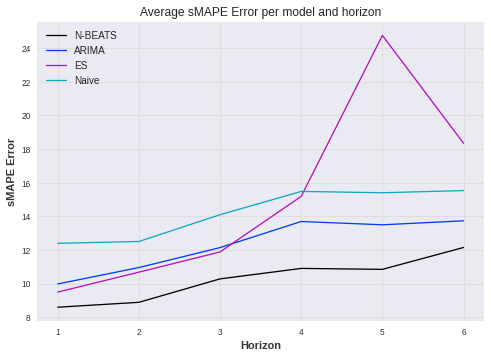

In [1622]:
# Plot
df_res.plot(title = "Average sMAPE Error per model and horizon",
            xlabel="Horizon", ylabel = "sMAPE Error");

For N-BEATS, ARIMA and Naive forecasts, the error grows at a similar rate with respect to the forecasting horizon, unlike exponential smoothing whose errors explode for higher horizons.

# Experiments on model training

The official implementation of the paper is just designed to reproduce the paper's experiments and doesn't allow us to specify other training data or easily control the parameters of the model. Therefore we built a new N-BEATS class with a sklearn-like API (define-fit-predict) to make our experiments easier. This implementation can also be useful for other practitioners who want to use N-BEATS on their own series, and provides better performance (in our experiments) than the Darts implementation, and an easier interface than the official implementation.

In [1834]:
def fix_groups(groups):
    # Fix seasonality names (they aren't consistent across the predefined datasets)
    fixed = {'M3Month':'Month', 'M3Other':'Other', 'M3Quart':'Quarter', 'M3Year':'Year',
            'Daily':'Day', 'Hourly':'Hour', 'Monthly':'Month', 'Quarterly':'Quarter',
             'Weekly':'Week', 'Yearly':'Year'}
    return(np.vectorize(fixed.get)(groups))

class dataset():
    """Create dataset object to store the series
    methods: -'load' to load a predefined dataset
             - 'from_values' to load series from a numpy array"""
    def __init__(self):
        pass
    def load(self, name, seasonal_pattern=None, training=True):
        """
        Load one of the available datasets
        seasonal_pattern: 'Hour', 'Day', 'Week', 'Month', 'Quart', 'Year', or 'Other'
        """
        name = name.lower()
        if name=="m3":
            from datasets.m3 import M3Dataset
            loaded_dataset = M3Dataset.load(training=training)
        elif name=="m4":
            from datasets.m4 import M4Dataset
            loaded_dataset = M4Dataset.load(training=training)
        elif name=="electricity":
            from datasets.electricity import ElectricityDataset
            loaded_dataset = ElectricityDataset.load()
            training_set, test_set = loaded_dataset.split_by_date('2014-12-25 00')
            loaded_dataset = training_set if training else test_set
        elif name=="tourism":
            from datasets.tourism import TourismDataset
            loaded_dataset = TourismDataset.load(training=training)
        elif name=="traffic":
            from datasets.traffic import TrafficDataset
            loaded_dataset = TrafficDataset.load()
            training_set, test_set = loaded_dataset.split_by_date('2008-06-14 23')
            loaded_dataset = training_set if training else test_set
        if name in ["m3","m4","tourism"]:
            if seasonal_pattern is None:
                raise Exception("Argument seasonal_pattern is required for this dataset")
            seasonal_pattern = seasonal_pattern.capitalize()
            # those datasets contain several seasonalities, choose one
            loaded_dataset.groups = fix_groups(loaded_dataset.groups)
            self.values = np.array([v[~np.isnan(v)] for v in
                                    loaded_dataset.values[loaded_dataset.groups == seasonal_pattern]],
                                   dtype=object)
            self.ids = loaded_dataset.ids[loaded_dataset.groups == seasonal_pattern]
        else:
            self.values = loaded_dataset.values
            self.ids = loaded_dataset.ids
        if len(self.values)==0:
            raise Exception(f'No values found')
            
    def from_values(self, values):
        self.values = np.array([values[i] for i in range(len(values))], dtype=object)
        self.ids = np.vectorize(str)(np.array(range(len(values))))
        
    def subset(self, indices):
        self.values = self.values[indices]
        self.ids = self.ids[indices]
    
    def __len__(self):
        return(len(self.values))

In [1716]:
def __loss_fn(loss_name: str):
    def loss(x, freq, forecast, target, target_mask):
        if loss_name == 'MAPE':
            return mape_loss(forecast, target, target_mask)
        elif loss_name == 'MASE':
            return mase_loss(x, freq, forecast, target, target_mask)
        elif loss_name == 'SMAPE':
            return smape_2_loss(forecast, target, target_mask)
        else:
            raise Exception(f'Unknown loss function: {loss_name}')

    return loss

def trainer(model: t.nn.Module,
            training_set: Iterator,
            timeseries_frequency: int,
            loss_name: str,
            iterations: int,
            learning_rate: float = 0.001):

    model = model.to(t.device('cuda' if t.cuda.is_available() else 'cpu'))
    optimizer = t.optim.Adam(model.parameters(), lr=learning_rate)

    training_loss_fn = __loss_fn(loss_name)

    lr_decay_step = iterations // 3
    if lr_decay_step == 0:
        lr_decay_step = 1

    # Training Loop
    iteration = 0
    losses = []
    model.train()
    for i in range(iteration + 1, iterations + 1):

        x, x_mask, y, y_mask = map(to_tensor, next(training_set))
        optimizer.zero_grad()
        forecast = model(x, x_mask)
        training_loss = training_loss_fn(x, timeseries_frequency, forecast, y, y_mask)

        if np.isnan(float(training_loss)):
            break

        training_loss.backward()
        t.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        for param_group in optimizer.param_groups:
            param_group["lr"] = learning_rate * 0.5 ** (i // lr_decay_step)
        losses.append(float(training_loss))
    return model, losses

In [1808]:
# Useful global variables
seasonal_patterns = ['Year', 'Quarter', 'Month', 'Other']
history_size = {'Year': 20,'Quarter': 5,'Month': 5,'Other': 20}
horizons_map = {'Year': 6, 'Quarter': 8, 'Month': 18, 'Other': 8}
iterations = {'Year': 50, 'Quarter': 6000, 'Month': 6000, 'Other': 250}
frequency_map = {'Year': 1,'Quart': 4,'Month': 12,'Other': 1}

In [1806]:
def define(default, param_name, cfg):
    return cfg[param_name] if (param_name in cfg.keys()) else default

def make_sure_doesnt_exist(path):
    # if the specified path exists, append a number to it or increment its last number
    while os.path.exists(path):
        superpath,basename = os.path.split(path)
        save_num = re.findall(r'\d+$', basename)
        if len(save_num)==0:
            basename = basename + "1"
        else:
            basename = basename[:(-len(save_num[-1]))] + str(int(save_num[-1])+1)
        path = os.path.join(superpath, basename)
    return(path)
    
class NBeats():
    def __init__(self, cfg={}):
        # Model configuration
        # Default values are the ones used in the M3 experiment
        self.lookback = define(2, "lookback", cfg)
        self.loss = define("SMAPE", "loss", cfg)
        self.seasonal_pattern = define('Month', "seasonal_pattern", cfg)
        self.model_type = define('interpretable', "model_type", cfg)
        
        self.iterations = define(iterations[self.seasonal_pattern], "iterations", cfg)
        self.frequency = define(frequency_map[self.seasonal_pattern], "frequency", cfg)
        
        self.sp_history_size = history_size[self.seasonal_pattern]
        self.horizon = horizons_map[self.seasonal_pattern]
        self.input_size = self.lookback * self.horizon
        
        if "experiment_name" in cfg.keys():
            self.experiment_name = cfg["experiment_name"]
        else:
            self.experiment_name = "experiment1"
            # Make sure experiment name path doesn't already exist
            self.experiment_name = os.path.basename(make_sure_doesnt_exist(os.path.join('saves', self.experiment_name)))
        
        if "save_name" in cfg.keys():
            self.save_name = cfg["save_name"]
        else:
            self.save_name = f"{self.lookback}{self.loss}0"
            # Make sure save path doesn't already exist
            self.save_name = os.path.basename(make_sure_doesnt_exist(os.path.join('saves', self.experiment_name, self.save_name)))
        
        # Interpretable-specific config
        self.seasonality_layer_size = 2048
        self.seasonality_blocks = 3
        self.seasonality_layers = 4
        self.trend_layer_size = 256
        self.degree_of_polynomial = 2
        self.trend_blocks = 3
        self.trend_layers = 4
        self.num_of_harmonics = 1
        
        # generic-specific config
        self.layer_size = 512
        self.layers = 4
        self.stacks = 30
        
        # Model definition
        if self.model_type == 'interpretable':
            self.model = interpretable(input_size=self.input_size, output_size=self.horizon, trend_blocks=self.trend_blocks,
                                  trend_layers=self.trend_layers, trend_layer_size=self.trend_layer_size,
                                  degree_of_polynomial=self.degree_of_polynomial, seasonality_blocks=self.seasonality_blocks,
                                  seasonality_layers=self.seasonality_layers, seasonality_layer_size=self.seasonality_layer_size,
                                  num_of_harmonics=self.num_of_harmonics)
        elif self.model_type == 'generic':
            self.model = generic(input_size=self.input_size, output_size=self.horizon, layer_size=self.layer_size,
                           layers=self.layers, stacks=self.stacks)
        else:
            raise Exception(f'Unknown model type {self.model_type}')
    
    
    def fit(self, dataset):
        # Training set sampler
        training_set = TimeseriesSampler(timeseries=dataset.values,
                                         insample_size=self.input_size,
                                         outsample_size=self.horizon,
                                         window_sampling_limit=int(self.sp_history_size * self.horizon))

        # Train model      
        self.model, self.losses = trainer(model=self.model, training_set=iter(training_set),
                                          timeseries_frequency=self.frequency, loss_name=self.loss,
                                          iterations=self.iterations)
    
    def predict(self, dataset, save=True):
        test_set = TimeseriesSampler(timeseries=dataset.values,
                                         insample_size=self.input_size,
                                         outsample_size=self.horizon,
                                         window_sampling_limit=int(self.sp_history_size * self.horizon))
        forecasts = []
        x, x_mask = map(to_tensor, test_set.last_insample_window())
        self.model.eval()
        with t.no_grad():
            forecasts.extend(self.model(x, x_mask).cpu().detach().numpy())
        # Save predictions
        forecasts_df = pd.DataFrame(forecasts, columns=[f'V{i + 1}' for i in range(self.horizon)])
        forecasts_df.index = dataset.ids
        forecasts_df.index.name = 'id'
        if save:
            outdir = os.path.join('saves', self.experiment_name, self.save_name)
            os.makedirs(outdir, exist_ok=True)
            forecasts_df.to_csv(os.path.join(outdir, 'forecast.csv'))
        return(forecasts_df)
    
    def save(self, dir_path=None):
        if dir_path is None:
            dir_path = os.path.join('saves', self.experiment_name, self.save_name)
        os.makedirs(dir_path, exist_ok=True)
        joblib.dump(self, os.path.join(dir_path, 'model.pkl'))
        
    def increment_save_name(self):
        # Increments the model name, so next model and prediction saves will be in a new folder
        # instead of overwriting the old ones
        save_name, save_num = re.findall(r'^(.*[a-zA-Z]+)(\d+)$', self.save_name)[0]
        self.save_name = save_name + str(int(save_num) + 1)
    
def load_model(experiment_name, save_name):
    dir_path = os.path.join('saves', experiment_name, save_name, 'model.pkl')
    return(joblib.load(dir_path))

In [1796]:
# redefine the calc_error function for 1 seasonal pattern
def calc_error(test_set, ens, error="smape", indices=None, horizons=None):
    """Calculate the error metrics given the forecasts (ens) and target dataset (test_set)"""
    # initialization
    if indices is None:  # indices: series indices to be considered, the others are ignored
        indices = list(range(len(ens)))
    indices = [x in indices for x in range(len(ens))] # convert to list of bools
    target_values = test_set.values[indices]
    target_values = np.array([target_values[i] for i in range(len(target_values))])
    if not(horizons is None): target_values = target_values[:,horizons]
    # forecast values (as ndarray)
    forecast_values = ens.iloc[indices].dropna(axis=1).to_numpy()
    if not(horizons is None): forecast_values = forecast_values[:,horizons]
    # Calculate the error
    error = error.lower()
    sp_error = eval(f"{error}(forecast_values, target_values)")
    return(sp_error)

## Number of training epochs needed
Here 'epoch' indicates a number of iterations equal to the number of series (i.e. one pass over the data). Here we would like to calculate the error obtained after training for 1 epoch, 2 epochs, etc.. to find the optimal number of training epochs and evaluate the time required to train the model for the optimal number of epochs.

In [1756]:
train_set = dataset()
train_set.load("m3", "month")

In [1757]:
len(train_set)

1428

In [1804]:
lookbacks = [2, 3, 4, 5, 6, 7]
losses = ['MASE', 'MAPE', 'SMAPE']
for lookback in lookbacks:
    for loss in losses:
        model = NBeats({'seasonal_pattern':'Month', 'iterations':1428, 'experiment_name':"experiment1",
                       "lookback":lookback, "loss":loss})
        for epoch in tqdm(range(10)):
            model.fit(train_set)
            model.predict(train_set, save=True)
            if epoch<9: model.increment_save_name()
        model.save()

100%|██████████| 10/10 [10:14<00:00, 61.41s/it]


In [1809]:
df = get_forecasts("saves/experiment1/**/forecast.csv")
df

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V12,V13,V14,V15,V16,V17,V18,lookback,loss,repeat
0,N1402,2310.6055,2335.9724,1996.44960,1953.93030,2348.34000,2118.17940,2393.9730,2910.57000,2850.52760,...,2163.2966,2375.2214,2990.22660,1938.3049,1491.29080,2205.2507,1376.4553,6,MAPE,5
1,N1403,272.4121,507.9102,780.71106,462.41833,635.30096,741.76636,350.5924,832.67633,491.80896,...,690.7398,886.1873,351.52127,553.3878,461.04666,981.6720,933.3266,6,MAPE,5
2,N1404,6208.4520,6207.2715,4617.71340,4965.58640,5386.64700,5874.97500,6087.4330,4129.58060,4364.21500,...,5787.7896,5408.5127,4877.92330,5182.0160,5812.23630,6499.6960,4724.4270,6,MAPE,5
3,N1405,3641.8320,3348.2007,2948.41430,2623.47660,2596.45000,2254.72070,1967.2094,2047.61550,1812.09440,...,1742.1910,1556.4161,1652.36230,1656.0132,1468.42300,1735.9543,2059.1433,6,MAPE,5
4,N1406,7875.9883,8078.3706,6876.17200,7676.70300,8583.35900,11284.08200,9262.4670,7454.42140,10179.10000,...,7764.5350,7074.0070,5411.88870,7505.7427,7695.10200,8540.7070,8608.7030,6,MAPE,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,N2825,2660.7710,2678.7288,2652.56470,2641.95000,2644.02760,2637.67630,2597.2832,2565.16040,2518.81520,...,2552.1680,2545.9563,2572.45400,2551.4560,2528.57670,2576.8608,2577.9712,6,MAPE,8
1424,N2826,2471.6802,2466.4702,2586.60640,2530.47240,2525.02150,2419.13750,2395.7866,2422.91360,2402.91000,...,2515.9363,2485.5667,2450.28610,2488.1106,2450.28610,2599.6090,2664.5444,6,MAPE,8
1425,N2827,2548.4530,2583.1553,2603.91190,2516.54500,2504.18330,2443.33940,2401.2537,2380.18240,2416.32620,...,2338.3298,2308.5234,2363.49780,2403.6553,2367.75980,2489.1282,2544.0510,6,MAPE,8
1426,N2828,2918.3145,2936.6418,2952.52080,2940.05790,2953.28800,2948.42000,2953.3600,2945.93040,2970.49630,...,2980.2002,2976.6520,2967.98730,2959.6030,2933.05030,2887.8066,2916.7295,6,MAPE,8


In [1811]:
test_set = dataset()
test_set.load("M3", seasonal_pattern="Month", training=False)

In [1816]:
l_errors = []
for i in range(10):
    # Here the repeats indicate the epoch
    l_errors.append(calc_error(test_set, ensemble_forecasts(df, repeat=i)))

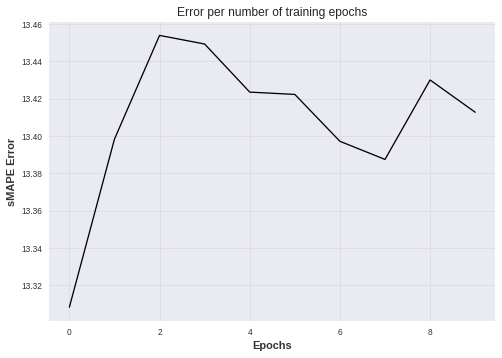

In [1817]:
plt.plot(l_errors)
plt.title("Error per number of training epochs")
plt.xlabel('Epochs')
plt.ylabel('sMAPE Error')
plt.show()

We see that training for one epoch is enough, training longer decreases the model's performance (overfitting). Given that every epoch takes 1 minute when training on the 1428 monthly M3 series, training an 18-model ensemble for 1 epoch takes 18 minutes, which is reasonable, although longer than most statistical methods.

## Size of the training dataset
Now we answer the question: Do we need a large set of training series to acheieve good performance? To do this we select a subset of 100 series, train the model on those series and predict them. We compare the obtained error with that of the model trained on the full 1428-series set.

In [1819]:
subset_indices = np.random.choice(len(train_set), size=100, replace=False)

In [1824]:
l_errors = []
for i in range(10):
    # Here the repeats indicate the epoch
    l_errors.append(calc_error(test_set, ensemble_forecasts(df, repeat=i), indices = subset_indices))

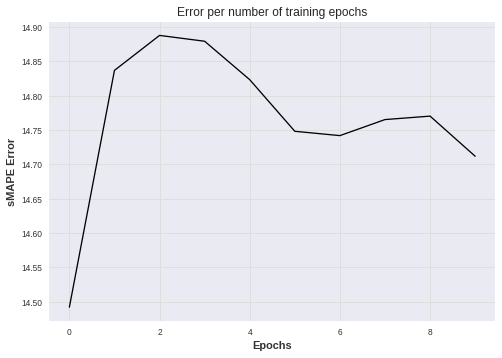

14.492228044613782


In [1826]:
# Error of the model trained on the full 1428-series set:
plt.plot(l_errors)
plt.title("Error per number of training epochs")
plt.xlabel('Epochs')
plt.ylabel('sMAPE Error')
plt.show()
print(l_errors[0])

In [1821]:
train_subset = dataset()
train_subset.load("m3", "month")
train_subset.subset(subset_indices)

In [1827]:
# Model trained on the 100-series subset
lookbacks = [2, 3, 4, 5, 6, 7]
losses = ['MASE', 'MAPE', 'SMAPE']
for lookback in lookbacks:
    for loss in losses:
        model = NBeats({'seasonal_pattern':'Month', 'iterations':100, 'experiment_name':"experiment2",
                       "lookback":lookback, "loss":loss})
        model.fit(train_subset)
        model.predict(train_subset, save=True)

In [1897]:
test_subset = dataset()
test_subset.load("m3", "month", training=False)
test_subset.subset(subset_indices)
df = get_forecasts("saves/experiment2/**/forecast.csv")
calc_error(test_subset, ensemble_forecasts(df))

15.793077540714222

The error is 1.3% higher (in absolute terms) and 9% higher than the previous error, indicating that training on a large set is beneficial. But given that here we trained with a 14x smaller set, the performance of the model remains decent.

We check that this error increase is not due to the smaller number of iterations (we replace the number of iterations by 1428 instead of 100):

In [1837]:
lookbacks = [2, 3, 4, 5, 6, 7]
losses = ['MASE', 'MAPE', 'SMAPE']
for lookback in lookbacks:
    for loss in losses:
        model = NBeats({'seasonal_pattern':'Month', 'iterations':1428, 'experiment_name':"experiment3",
                       "lookback":lookback, "loss":loss})
        model.fit(train_subset)
        model.predict(train_subset, save=True)

In [1898]:
df = get_forecasts("saves/experiment3/**/forecast.csv")
calc_error(test_subset, ensemble_forecasts(df))

16.026627220217563

## Qualitative model assessment

We visualize some predictions of the 18-model ensemble trained on the full monthly set (for 1 epoch):

In [1936]:
df = get_forecasts("saves/experiment1/**/forecast.csv")
ens = ensemble_forecasts(df, repeat=0)

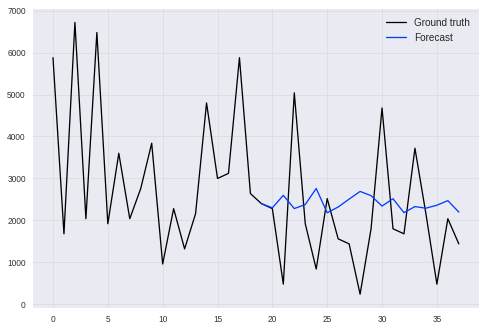

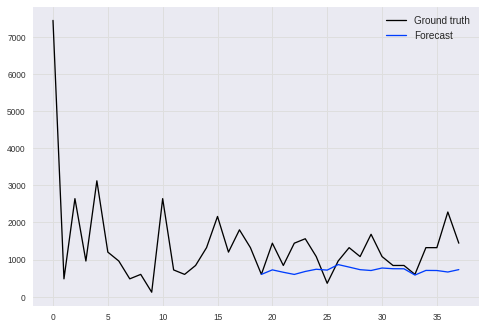

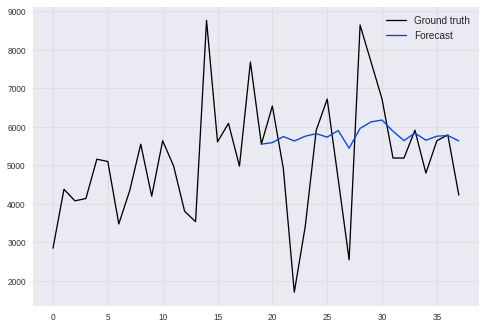

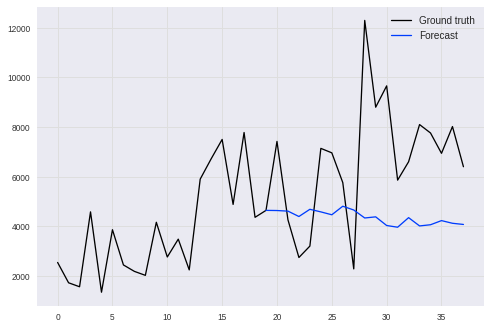

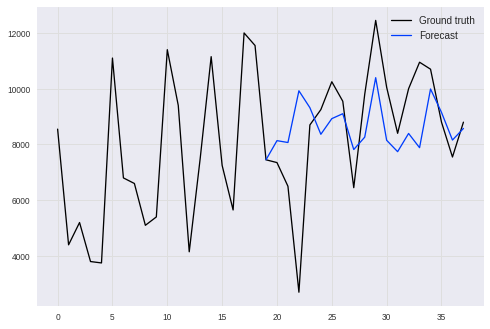

In [1937]:
ground_truth = pd.concat([pd.DataFrame([x[-20:] for x in train_set.values[:5]]),
pd.DataFrame([x for x in test_set.values[:5]])], axis=1).transpose().reset_index(drop=True)
forecasts = pd.concat([pd.DataFrame([[np.nan]*19+[x[-1]] for x in train_set.values[:5]]),
ens.iloc[:5].reset_index(drop=True)], axis=1).transpose().reset_index(drop=True)
df_plot = pd.concat([ground_truth, forecasts], axis=1)
for i in range(5):
    ax = df_plot.iloc[:,[i,i+5]].plot()
    ax.legend(["Ground truth", "Forecast"])

The forecasts look reasonable; those series don't have a clear pattern and are hard to predict.

Let's try the model on a selection of synthetic series:

In [2031]:
generated_series = []
# constant
generated_series.append(np.array([1]*68))
# constant + gaussian noise
generated_series.append(1+np.random.randn(68))
# linear
generated_series.append(np.linspace(1, 68, 68))
# linear + gaussian noise
generated_series.append(np.linspace(1, 68, 68)+np.random.randn(68))
# sine, low frequency
generated_series.append(np.sin(np.linspace(0, 2*np.pi, 68))+1)
# sine, low frequency, with an outlier
sine_with_outlier = np.sin(np.linspace(0, 2*np.pi, 68))+1
sine_with_outlier[35] = 10
generated_series.append(sine_with_outlier)
# sine, high frequency
generated_series.append(np.sin(np.linspace(0, 20*np.pi, 68))+1)
# sine, high frequency, with an outlier
sine_with_outlier = np.sin(np.linspace(0, 20*np.pi, 68))+1
sine_with_outlier[35] = 10
generated_series.append(sine_with_outlier)
# Square
generated_series.append(scipy.signal.square(np.linspace(0, 10*np.pi, 68)))
# Triangular
generated_series.append(scipy.signal.sawtooth(0.448798 *np.linspace(0, 67, 68), 0.5)+1)
# exponential
generated_series.append(np.exp(np.linspace(1, 11, 68))+1)
generated_series = np.array(generated_series)

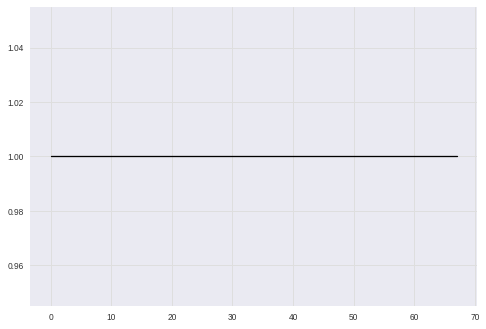

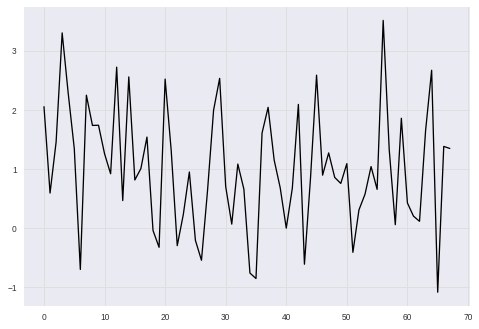

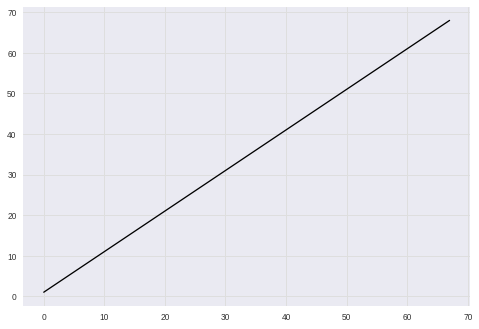

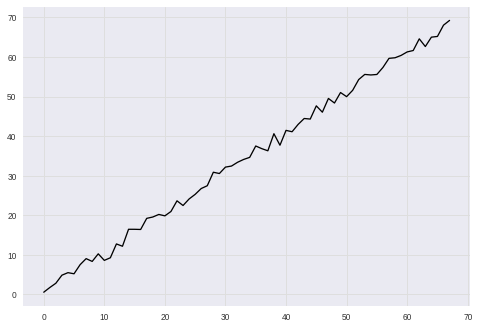

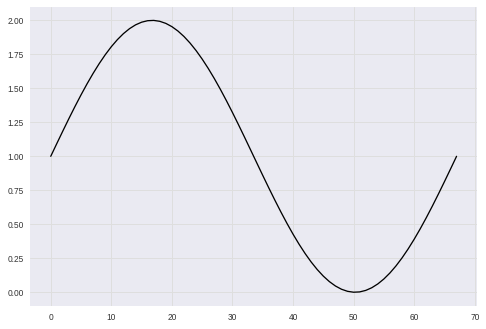

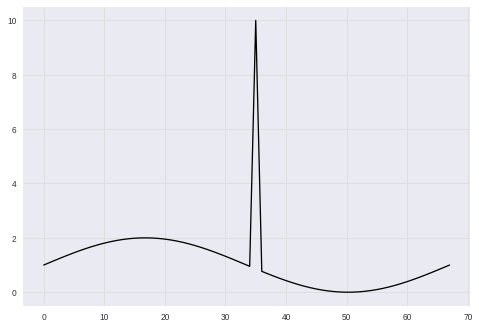

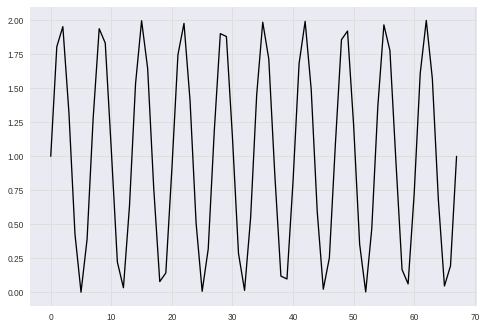

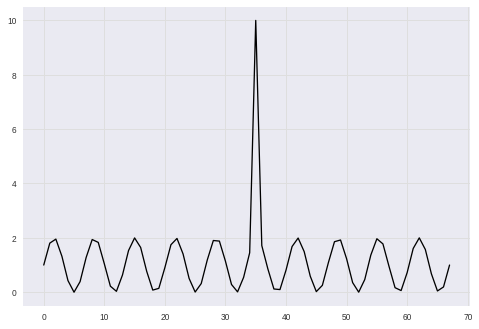

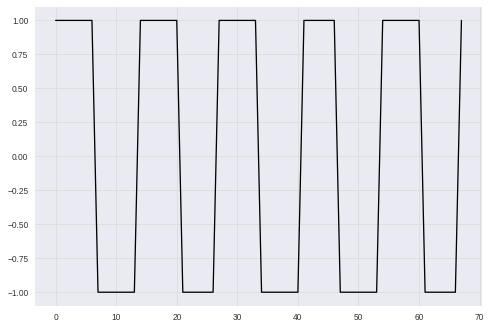

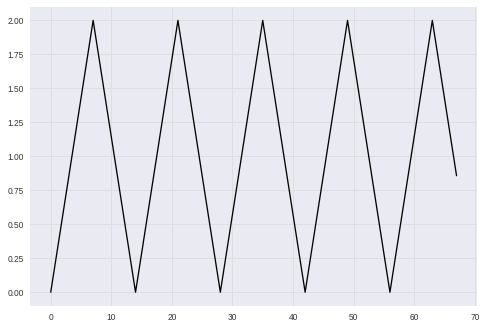

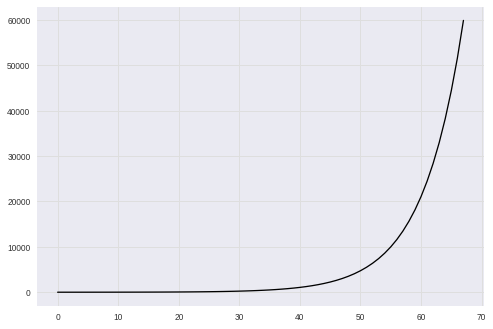

In [2032]:
for i in range(len(generated_series)):
    plt.plot(generated_series[i]); plt.show()

In [2033]:
gen_train_set = dataset() # generated training set
gen_train_set.from_values(generated_series[:,:50])
gen_test_set = dataset() # generated test set
gen_test_set.from_values(generated_series[:,50:])

In [2041]:
for lookback in lookbacks:
    for loss in losses:
        model = NBeats({'seasonal_pattern':'Month', 'iterations':1428, 'experiment_name':"experiment4",
                       "lookback":lookback, "loss":loss})
        model.fit(train_set)
        model.predict(gen_train_set, save=True)
        model.save()

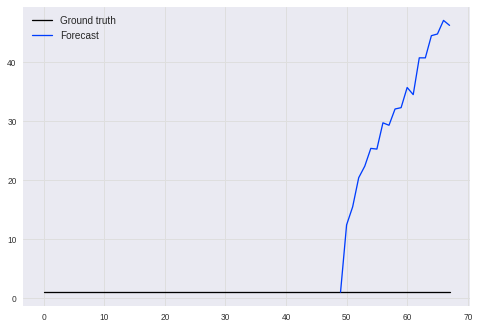

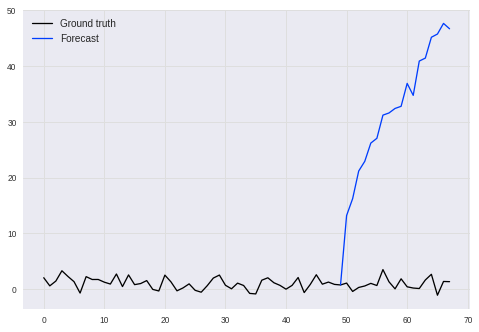

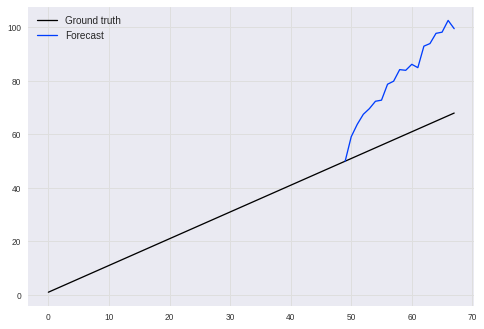

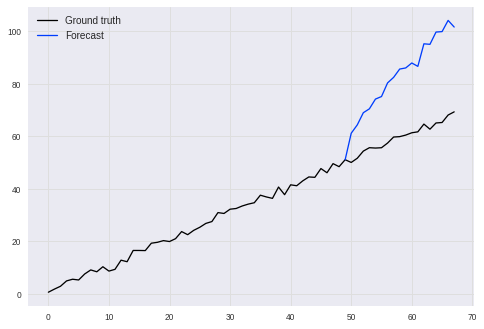

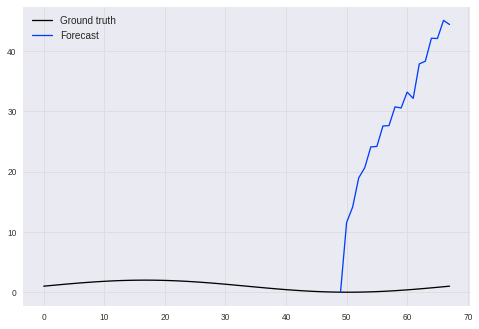

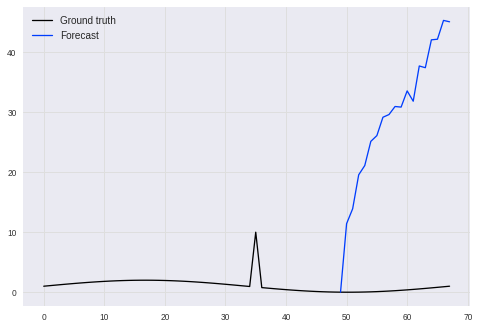

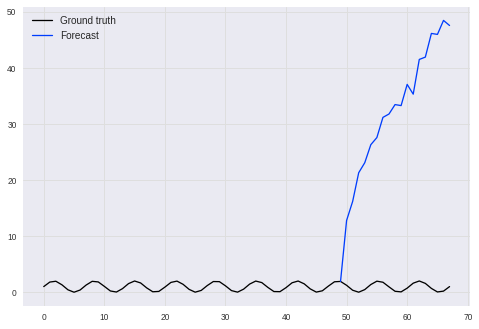

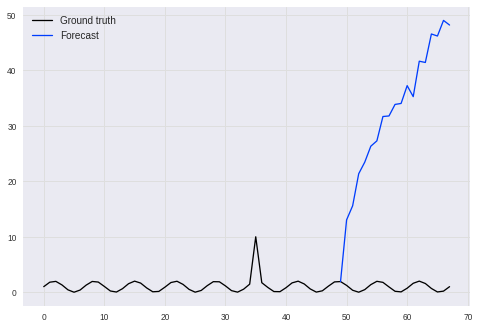

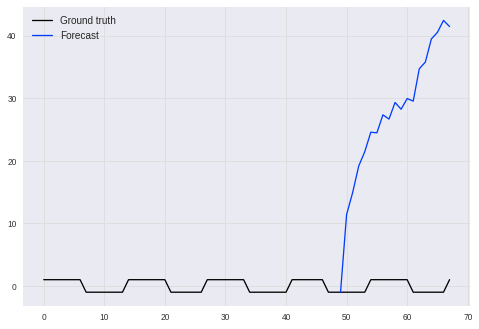

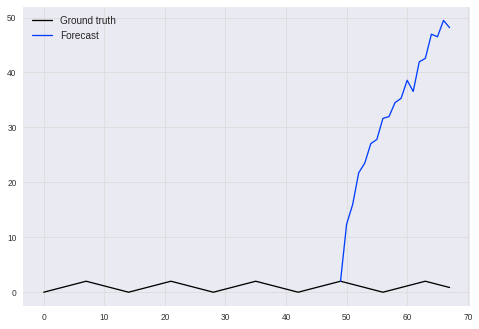

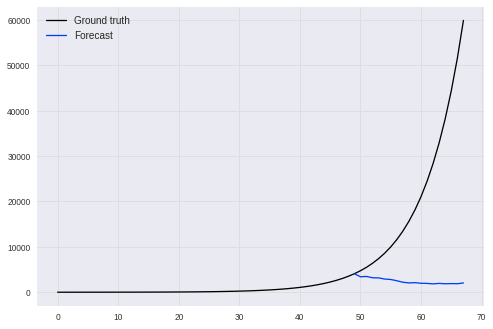

In [2043]:
# Plot the series and forecasts
df = get_forecasts("saves/experiment4/**/forecast.csv")
ens = ensemble_forecasts(df)
n_series = len(gen_train_set)
series_len = len(gen_train_set.values[0])
ground_truth = pd.concat([pd.DataFrame([x for x in gen_train_set.values]),
pd.DataFrame([x for x in gen_test_set.values])], axis=1).transpose().reset_index(drop=True)
forecasts = pd.concat([pd.DataFrame([[np.nan]*(series_len-1)+[x[-1]] for x in gen_train_set.values]),
ens.reset_index(drop=True)], axis=1).transpose().reset_index(drop=True)
df_plot = pd.concat([ground_truth, forecasts], axis=1)
for i in range(n_series):
    ax = df_plot.iloc[:,[i,i+n_series]].plot()
    ax.legend(["Ground truth", "Forecast"])

We see that the model doesn't work on those series and tends to forecast high values. The cause might be that it was trained on values ranging mostly between 3000 and 6000 (for the M3 monthly dataset), so it doesn't work when the training series and forecasted series have different orders of magnitude. We try to fix this by scaling the generated series:

In [2090]:
# min_max scaling (based on the train set)
generated_series_scaled = [np.array([4500]*68)]
for i in range(1, n_series):
    series_min = np.min(generated_series[i,:50])
    series_max = np.max(generated_series[i,:50])
    scaled = 3500 + 2000*(generated_series[i]-series_min)/(series_max-series_min)
    generated_series_scaled.append(scaled)
generated_series_scaled = np.array(generated_series_scaled)

# create dataset
scaled_gen_train_set = dataset() # generated training set
scaled_gen_train_set.from_values(generated_series_scaled[:,:50])
scaled_gen_test_set = dataset() # generated test set
scaled_gen_test_set.from_values(generated_series_scaled[:,50:])

# make predictions
for lookback in lookbacks:
    for loss in losses:
        model = load_model("experiment4",f"{lookback}{loss}0")
        model.experiment_name = "experiment5"
        model.predict(scaled_gen_train_set, save=True)

In [2100]:
mape(df.iloc[0,1:19].to_numpy(), scaled_gen_test_set.values[0])

0.5391039506172833

MAPE : 0.54 %


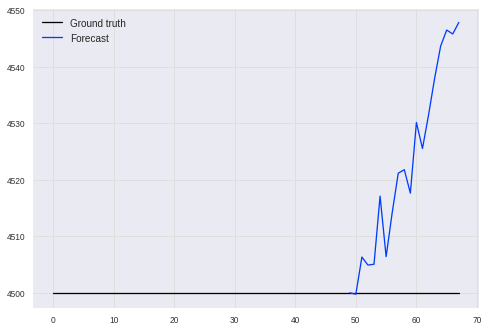

MAPE : 9.56 %


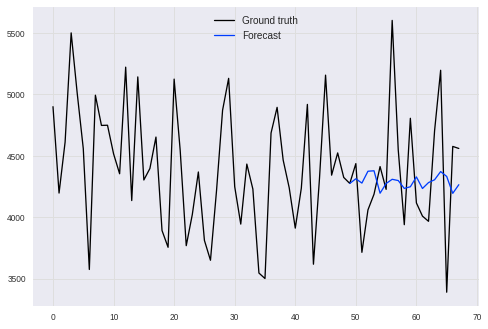

MAPE : 0.89 %


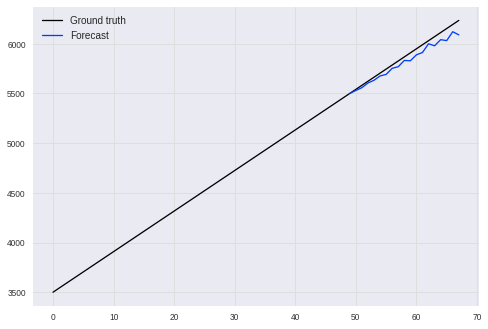

MAPE : 0.68 %


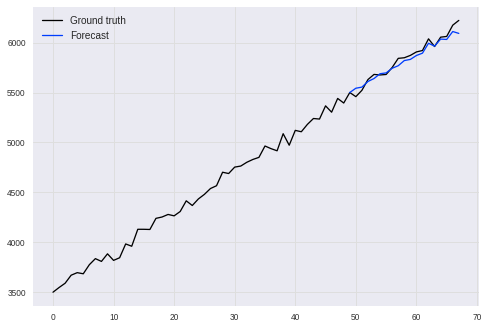

MAPE : 9.48 %


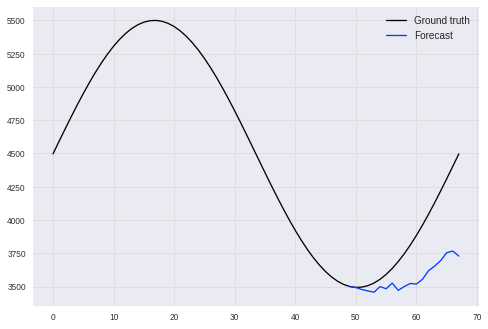

MAPE : 2.28 %


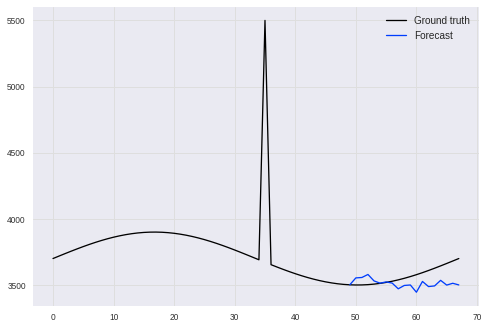

MAPE : 14.94 %


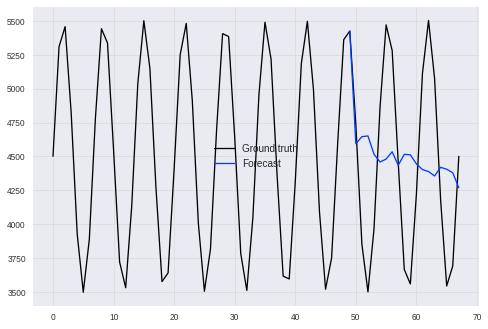

MAPE : 3.94 %


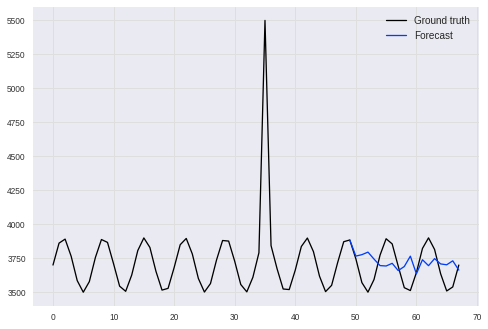

MAPE : 18.31 %


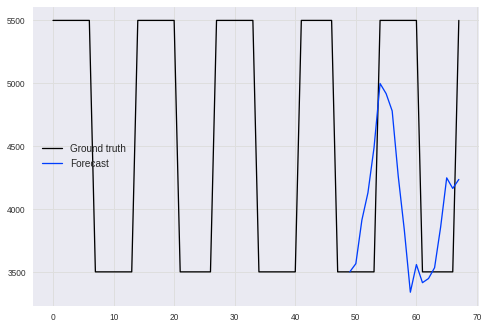

MAPE : 18.15 %


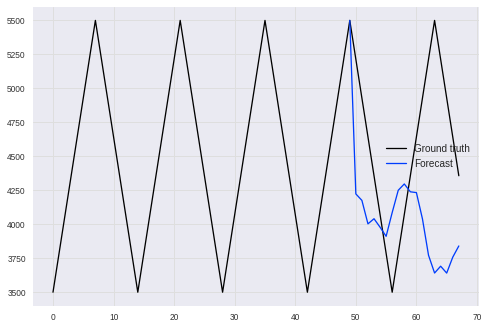

MAPE : 50.58 %


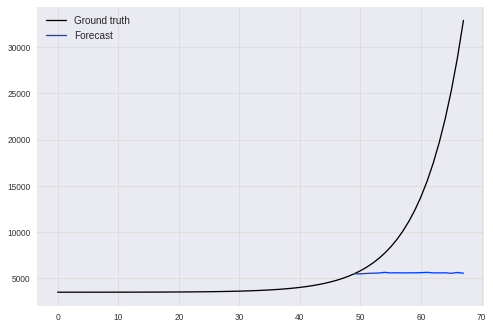

In [2105]:
# Plot the series and forecasts
df = get_forecasts("saves/experiment5/**/forecast.csv")
ens = ensemble_forecasts(df)
ground_truth = pd.concat([pd.DataFrame([x for x in scaled_gen_train_set.values]),
pd.DataFrame([x for x in scaled_gen_test_set.values])], axis=1).transpose().reset_index(drop=True)
forecasts = pd.concat([pd.DataFrame([[np.nan]*(series_len-1)+[x[-1]] for x in scaled_gen_train_set.values]),
ens.reset_index(drop=True)], axis=1).transpose().reset_index(drop=True)
df_plot = pd.concat([ground_truth, forecasts], axis=1)
for i in range(n_series):
    print(f"MAPE : {mape(df.iloc[i,1:19].to_numpy(), scaled_gen_test_set.values[i]):.2f} %")
    ax = df_plot.iloc[:,[i,i+n_series]].plot()
    ax.legend(["Ground truth", "Forecast"], loc='best')
    plt.show()

The forecasts are decent, although they don't capture the patterns well, probably because we used the model trained on M3 monthly without further training it on this generated dataset. Now we train it on this dataset and compare the results:

In [2106]:
# train and forecast
for lookback in lookbacks:
    for loss in losses:
        model = load_model("experiment4",f"{lookback}{loss}0")
        model.experiment_name = "experiment6"
        model.iterations = n_series*2
        model.fit(scaled_gen_train_set)
        model.predict(scaled_gen_train_set, save=True)

MAPE : 1.53 %


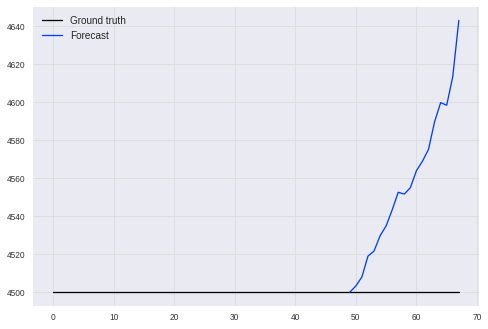

MAPE : 8.73 %


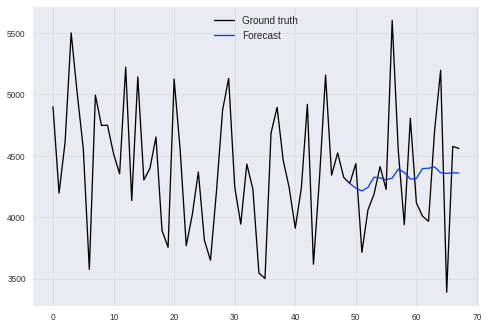

MAPE : 1.98 %


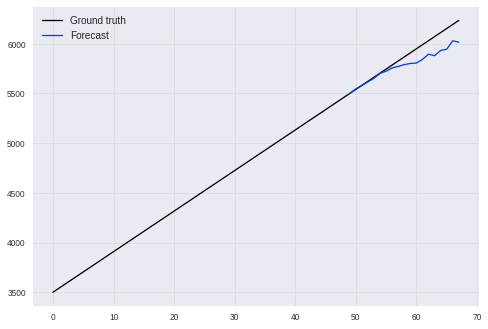

MAPE : 1.80 %


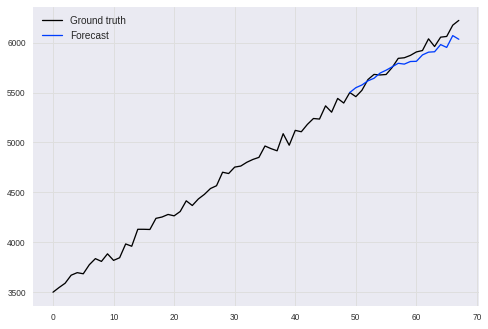

MAPE : 6.87 %


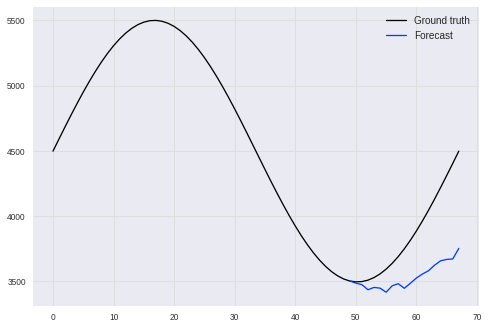

MAPE : 3.78 %


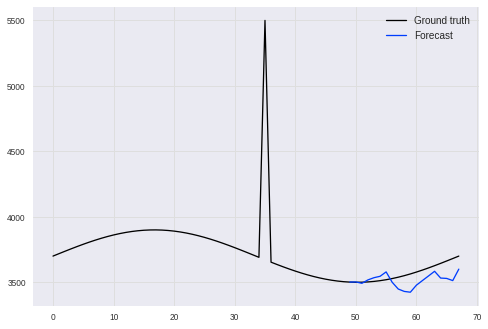

MAPE : 6.50 %


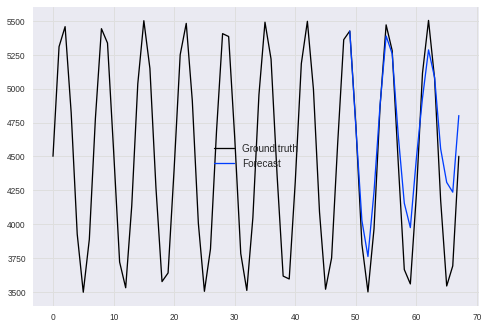

MAPE : 2.15 %


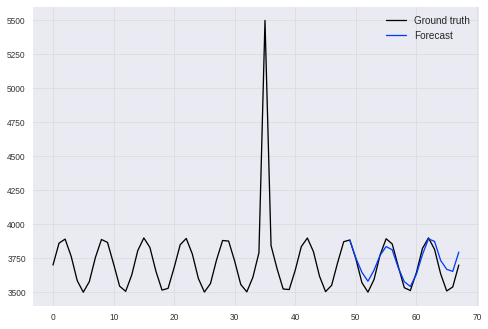

MAPE : 12.14 %


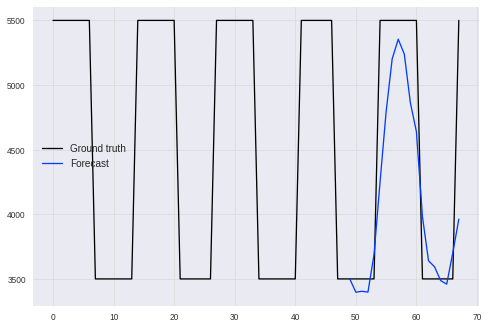

MAPE : 2.70 %


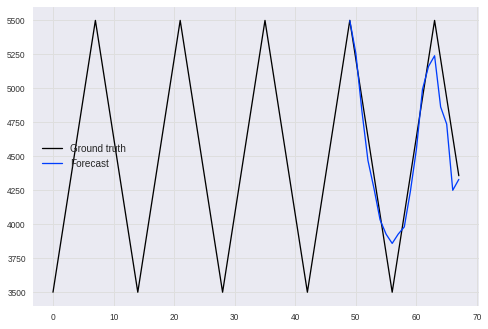

MAPE : 34.39 %


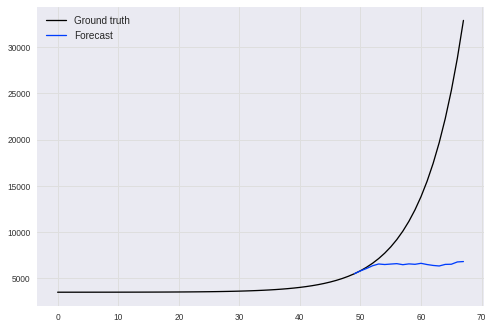

In [2107]:
# Plot the series and forecasts
df = get_forecasts("saves/experiment6/**/forecast.csv")
ens = ensemble_forecasts(df)
ground_truth = pd.concat([pd.DataFrame([x for x in scaled_gen_train_set.values]),
pd.DataFrame([x for x in scaled_gen_test_set.values])], axis=1).transpose().reset_index(drop=True)
forecasts = pd.concat([pd.DataFrame([[np.nan]*(series_len-1)+[x[-1]] for x in scaled_gen_train_set.values]),
ens.reset_index(drop=True)], axis=1).transpose().reset_index(drop=True)
df_plot = pd.concat([ground_truth, forecasts], axis=1)
for i in range(n_series):
    print(f"MAPE : {mape(df.iloc[i,1:19].to_numpy(), scaled_gen_test_set.values[i]):.2f} %")
    ax = df_plot.iloc[:,[i,i+n_series]].plot()
    ax.legend(["Ground truth", "Forecast"], loc='best')
    plt.show()

We can see that most of the forecasts are improved and managed to partially capture the pattern of the series. We can try training for more epochs:

MAPE : 1.05 %


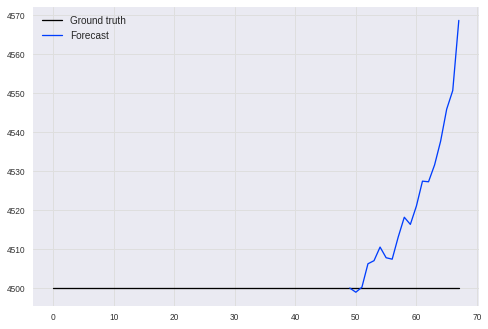

MAPE : 9.25 %


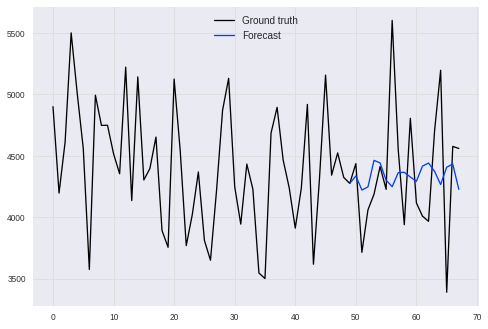

MAPE : 1.32 %


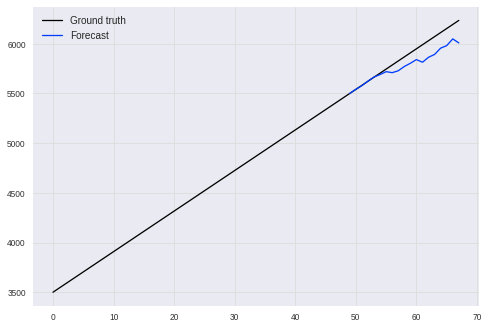

MAPE : 1.08 %


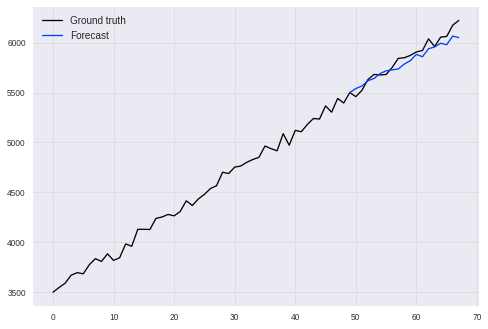

MAPE : 9.52 %


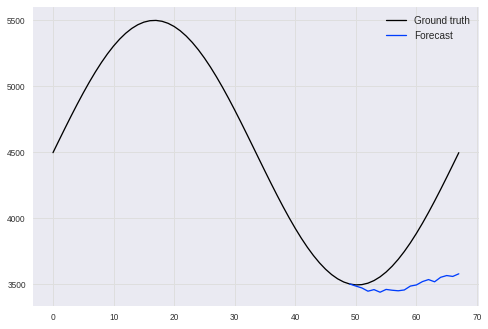

MAPE : 3.94 %


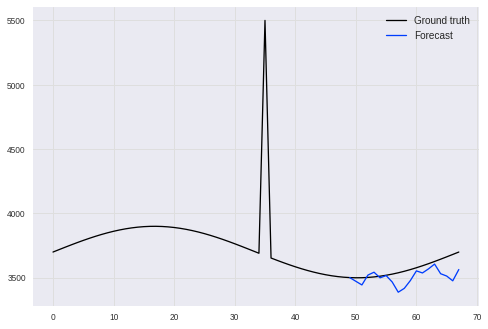

MAPE : 7.67 %


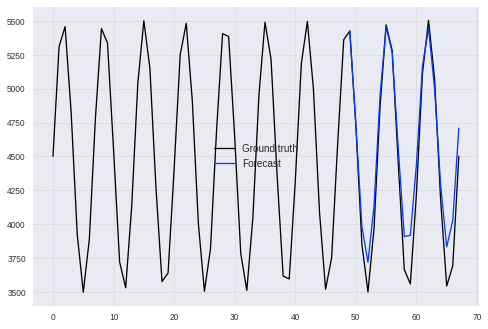

MAPE : 2.49 %


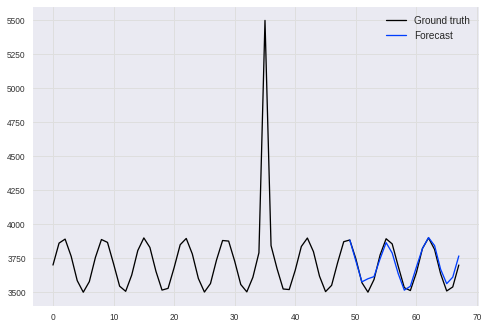

MAPE : 11.87 %


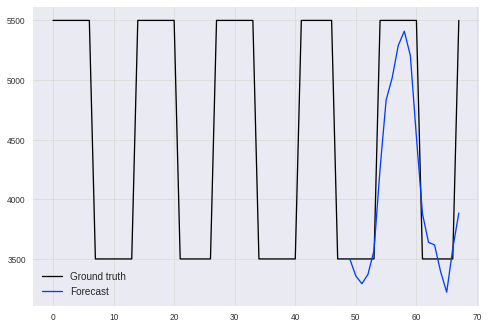

MAPE : 4.04 %


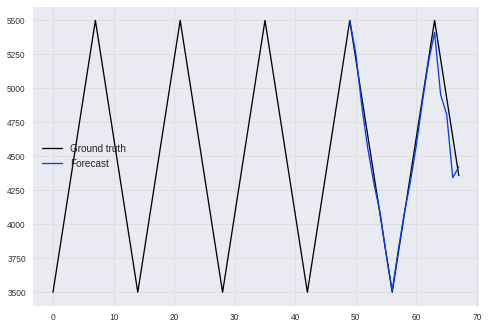

MAPE : 28.47 %


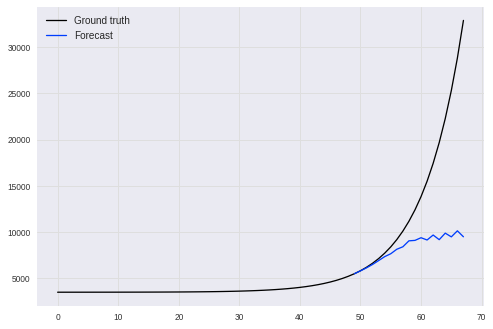

In [2108]:
# train and forecast
for lookback in lookbacks:
    for loss in losses:
        model = load_model("experiment4",f"{lookback}{loss}0")
        model.experiment_name = "experiment7"
        model.iterations = n_series*10
        model.fit(scaled_gen_train_set)
        model.predict(scaled_gen_train_set, save=True)
# Plot the series and forecasts
df = get_forecasts("saves/experiment7/**/forecast.csv")
ens = ensemble_forecasts(df)
ground_truth = pd.concat([pd.DataFrame([x for x in scaled_gen_train_set.values]),
pd.DataFrame([x for x in scaled_gen_test_set.values])], axis=1).transpose().reset_index(drop=True)
forecasts = pd.concat([pd.DataFrame([[np.nan]*(series_len-1)+[x[-1]] for x in scaled_gen_train_set.values]),
ens.reset_index(drop=True)], axis=1).transpose().reset_index(drop=True)
df_plot = pd.concat([ground_truth, forecasts], axis=1)
for i in range(n_series):
    print(f"MAPE : {mape(df.iloc[i,1:19].to_numpy(), scaled_gen_test_set.values[i]):.2f} %")
    ax = df_plot.iloc[:,[i,i+n_series]].plot()
    ax.legend(["Ground truth", "Forecast"], loc='best')
    plt.show()

Although not perfect, the obtained forecasts are rather satisfying. We note that for the constant series, the model seems to confuse it with the exponential series and makes an exponential forecast, but the error is only 1% which is fine. For the exponential series, the model extrapolates decently for a short horizon but then doesn't manage to predict values much higher than its training range. In such cases, the training set needs to be adapted to such series.

Overall, we can conclude that N-BEATS can efficiently capture and learn the patterns in the data, while also showing robustness towards outliers and noise in the data. It also proves that neural networks can outperform classical methods in time series forecasting, and lays the way for more research in this direction.